# 클러스터링 분석

## K-means, GMM, Spectral, HDBSCAN 클러스터링 적용

## XAI 해석 (SHAP, LIME, Permutation Importance 적용)

### 사용할 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# macOS에서 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스(-)가 깨질 수 있는 것을 방지함
plt.rcParams['axes.unicode_minus'] = False


### 데이터 불러오기 (window별 데이터)

In [3]:
# 절대경로로 불러옴
df_2020_2022 = pd.read_csv("../csv/financial_data_window_2020_2022.csv")
df_2021_2023 = pd.read_csv("../csv/financial_data_window_2021_2023.csv")
df_2022_2024 = pd.read_csv("../csv/financial_data_window_2022_2024.csv")

# 기업명을 따로 저장한 후, feature만 따로 분리함
company_2020_2022 = df_2020_2022['기업명_그룹']
company_2021_2023 = df_2021_2023['기업명_그룹']
company_2022_2024 = df_2022_2024['기업명_그룹']
X_raw_2020_2022 = df_2020_2022.drop(columns=["기업명_그룹"])
X_raw_2021_2023 = df_2021_2023.drop(columns=["기업명_그룹"])
X_raw_2022_2024 = df_2022_2024.drop(columns=["기업명_그룹"])

X_raw_2020_2022

,매출액,영업이익,당기순이익,자산총계,자본총계,자본금,영업활동현금흐름,이자발생부채,영업이익률,순이익률,ROE(%),ROA(%),부채비율,EPS(원),PER(배),BPS(원),PBR(배),발행주식수(보통주)
0,70985.166667,2197.000000,1664.000000,2.733767e+04,8672.000000,173.0,5791.166667,7519.166667,3.071667,2.326667,20.556667,6.370000,216.680000,9629.666667,18.258333,50201.166667,3.486667,17283906.0
1,65153.666667,10667.500000,7884.333333,1.302548e+06,104070.666667,16297.0,13934.833333,188141.666667,16.550000,12.281667,8.033333,0.630000,1150.475000,2278.500000,3.096667,29234.333333,0.236667,325935246.0
2,372903.000000,19360.833333,6464.000000,4.477637e+05,169206.666667,1790.0,36457.000000,181936.166667,5.175000,1.726667,4.171667,1.501667,164.290000,5808.000000,17.345000,150724.833333,0.565000,29176998.0
3,116434.333333,3747.500000,1749.333333,9.451867e+04,40292.666667,1141.0,5215.333333,32803.333333,3.213333,1.496667,3.723333,1.875000,134.561667,5678.333333,28.503333,176992.666667,0.658333,22812344.0
4,278437.666667,15670.833333,8298.833333,2.822718e+05,110611.666667,819.0,17094.166667,106516.166667,5.633333,3.008333,10.466667,3.048333,154.990000,37635.166667,10.200000,392853.166667,0.983333,15054186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,169082.333333,11569.000000,8470.166667,4.893132e+05,72241.666667,447.0,9939.333333,11728.833333,7.235000,5.293333,13.046667,1.703333,665.428333,9474.166667,3.616667,91999.166667,0.303333,89400000.0
187,42520.500000,478.666667,-632.833333,2.837017e+04,5662.000000,2000.0,1157.333333,16159.000000,0.873333,-1.751667,-9.115000,-2.041667,402.983333,-1582.166667,3.356680,14950.833333,5.455000,39248121.0
188,32839.500000,1189.833333,368.333333,4.304900e+04,10586.666667,466.0,677.500000,14398.833333,3.580000,1.130000,2.238333,0.911667,305.755000,2210.333333,34.394582,101515.833333,0.678333,9324548.0
189,81669.500000,5808.000000,3736.166667,4.139467e+04,14648.500000,216.0,4552.666667,14565.000000,7.075000,4.560000,30.030000,10.281667,193.871667,65943.333333,67.425000,274582.666667,1.400000,4327682.0


## 다중공선성 확인

### Window: 2020 ~ 2022

In [4]:
# 상수항 추가 (VIF 계산 시 필요)
X_with_const = sm.add_constant(X_raw_2020_2022)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

# 결과 확인
vif_data.sort_values("VIF", ascending=False)

,Feature,VIF
3,당기순이익,23.237646
2,영업이익,22.286116
5,자본총계,12.369585
14,EPS(원),8.917612
1,매출액,8.309715
16,BPS(원),8.092324
4,자산총계,7.685596
8,이자발생부채,6.880909
0,const,5.326411
6,자본금,5.025774


In [5]:
# 'const' 제외하고 VIF ≤ 10 인 피처만 선택
vif_threshold = 10
valid_features = vif_data[(vif_data["Feature"] != "const") & (vif_data["VIF"] <= vif_threshold)]["Feature"]

# 해당 feature들만 남긴 새로운 DataFrame 생성
X_raw_2020_2022 = X_raw_2020_2022[valid_features]


### Window: 2021 ~ 2023

In [6]:
# 상수항 추가 (VIF 계산 시 필요)
X_with_const = sm.add_constant(X_raw_2021_2023)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

# 결과 확인
vif_data.sort_values("VIF", ascending=False)

,Feature,VIF
2,영업이익,31.819736
3,당기순이익,30.261065
5,자본총계,13.197567
1,매출액,9.038077
8,이자발생부채,7.892144
4,자산총계,7.690996
0,const,5.888997
6,자본금,4.701214
12,ROA(%),4.012625
18,발행주식수(보통주),3.956254


In [7]:
# 'const' 제외하고 VIF ≤ 10 인 피처만 선택
vif_threshold = 10
valid_features = vif_data[(vif_data["Feature"] != "const") & (vif_data["VIF"] <= vif_threshold)]["Feature"]

# 해당 feature들만 남긴 새로운 DataFrame 생성
X_raw_2021_2023 = X_raw_2021_2023[valid_features]


### Window: 2022 ~ 2024

In [8]:
# 상수항 추가 (VIF 계산 시 필요)
X_with_const = sm.add_constant(X_raw_2022_2024)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

# 결과 확인
vif_data.sort_values("VIF", ascending=False)

,Feature,VIF
2,영업이익,32.017576
3,당기순이익,28.701173
5,자본총계,15.183636
1,매출액,12.047871
8,이자발생부채,8.734619
4,자산총계,7.836410
12,ROA(%),7.623210
11,ROE(%),5.614654
0,const,5.508169
14,EPS(원),5.285805


In [9]:
# 'const' 제외하고 VIF ≤ 10 인 피처만 선택
vif_threshold = 10
valid_features = vif_data[(vif_data["Feature"] != "const") & (vif_data["VIF"] <= vif_threshold)]["Feature"]

# 해당 feature들만 남긴 새로운 DataFrame 생성
X_raw_2022_2024 = X_raw_2022_2024[valid_features]


### featurer scaling 수행

In [10]:
# StandardScaler로 정규화한다.
scaler = StandardScaler()
X_scaled_2020_2022 = scaler.fit_transform(X_raw_2020_2022)
X_scaled_2021_2023 = scaler.fit_transform(X_raw_2021_2023)
X_scaled_2022_2024 = scaler.fit_transform(X_raw_2022_2024)
# X_scaled 데이터를 DataFrame으로 변환
X_scaled_df_2020_2022 = pd.DataFrame(X_scaled_2020_2022, columns=X_raw_2020_2022.columns)
X_scaled_df_2021_2023 = pd.DataFrame(X_scaled_2021_2023, columns=X_raw_2021_2023.columns)
X_scaled_df_2022_2024 = pd.DataFrame(X_scaled_2022_2024, columns=X_raw_2022_2024.columns)

# CSV 파일로 저장
# X_scaled_df_2020_2022.to_csv("../csv/X_scaled_2020_2022.csv", index=False, encoding="utf-8-sig")
# X_scaled_df_2021_2023.to_csv("../csv/X_scaled_2021_2023.csv", index=False, encoding="utf-8-sig")
# X_scaled_df_2022_2024.to_csv("../csv/X_scaled_2022_2024.csv", index=False, encoding="utf-8-sig")

# print("X_scaled 데이터가 'X_scaled.csv'로 저장되었습니다.")

### 클러스터링 적용 및 평가 함수 정의

In [11]:
# 클러스터링 성능 평가 함수를 정의함 
# Silhouette Score를 사용함
def evaluate_clustering(model, X, labels=None):
    if (labels is None):
        labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    return labels, score

### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2020-2022)

Best K for KMeans (lowest DBI): 26 -> DBI = 0.7244
Best K for GMM (lowest DBI): 26 -> DBI = 0.7265
Best K for Spectral Clustering (lowest DBI): 26 -> DBI = 1.4014


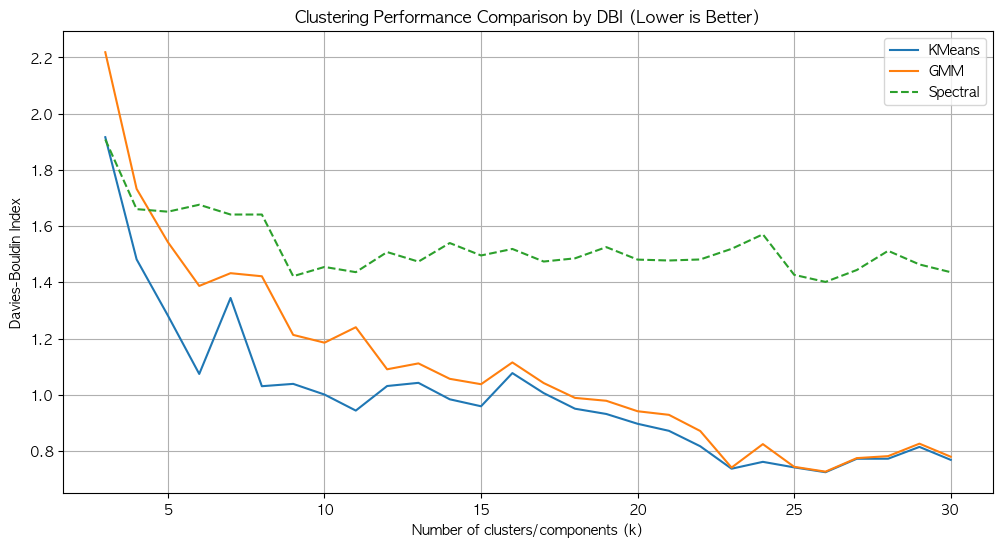

In [12]:
# 결과 저장
k_range = range(3, 31)

dbi_kmeans, dbi_gmm, dbi_spectral = [], [], []

labels_kmeans_all, labels_gmm_all, labels_spectral_all = {}, {}, {}

# 반복 수행
for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels_2020_2022 = kmeans.fit_predict(X_scaled_2020_2022)
    dbi_kmeans.append(davies_bouldin_score(X_scaled_df_2020_2022, kmeans_labels_2020_2022))
    labels_kmeans_all[k] = kmeans_labels_2020_2022

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2020_2022 = gmm.fit_predict(X_scaled_df_2020_2022)
    dbi_gmm.append(davies_bouldin_score(X_scaled_df_2020_2022, gmm_labels_2020_2022))
    labels_gmm_all[k] = gmm_labels_2020_2022

    # Spectral Clustering
    try:
        spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
        spectral_labels_2020_2022 = spectral.fit_predict(X_scaled_df_2020_2022)
        dbi_spectral.append(davies_bouldin_score(X_scaled_df_2020_2022, spectral_labels_2020_2022))
        labels_spectral_all[k] = spectral_labels_2020_2022

    except Exception:
        # 실패한 경우 큰 값으로 대체 (e.g., affinity 문제 등)
        dbi_spectral.append(np.inf)
        labels_spectral_all[k] = None


# 가장 낮은 DBI를 보이는 k 찾기
best_k_kmeans = k_range[np.argmin(dbi_kmeans)]
best_k_gmm = k_range[np.argmin(dbi_gmm)]
best_k_spectral = k_range[np.argmin(dbi_spectral)]

min_dbi_kmeans = min(dbi_kmeans)
min_dbi_gmm = min(dbi_gmm)
min_dbi_spectral = min(dbi_spectral)

# 3. 세 값 비교해서 최소값 및 방법 선택
dbi_dict = {
    'KMeans': (best_k_kmeans, min_dbi_kmeans),
    'GMM': (best_k_gmm, min_dbi_gmm),
    'Spectral': (best_k_spectral, min_dbi_spectral)
}

# 결과 출력
print(f"Best K for KMeans (lowest DBI): {best_k_kmeans} -> DBI = {min_dbi_kmeans:.4f}")
print(f"Best K for GMM (lowest DBI): {best_k_gmm} -> DBI = {min_dbi_gmm:.4f}")
print(f"Best K for Spectral Clustering (lowest DBI): {best_k_spectral} -> DBI = {min_dbi_spectral:.4f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, dbi_kmeans, label='KMeans')
plt.plot(k_range, dbi_gmm, label='GMM')
plt.plot(k_range, dbi_spectral, label='Spectral', linestyle='--')
plt.xlabel('Number of clusters/components (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Clustering Performance Comparison by DBI (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


### SHAP 분석

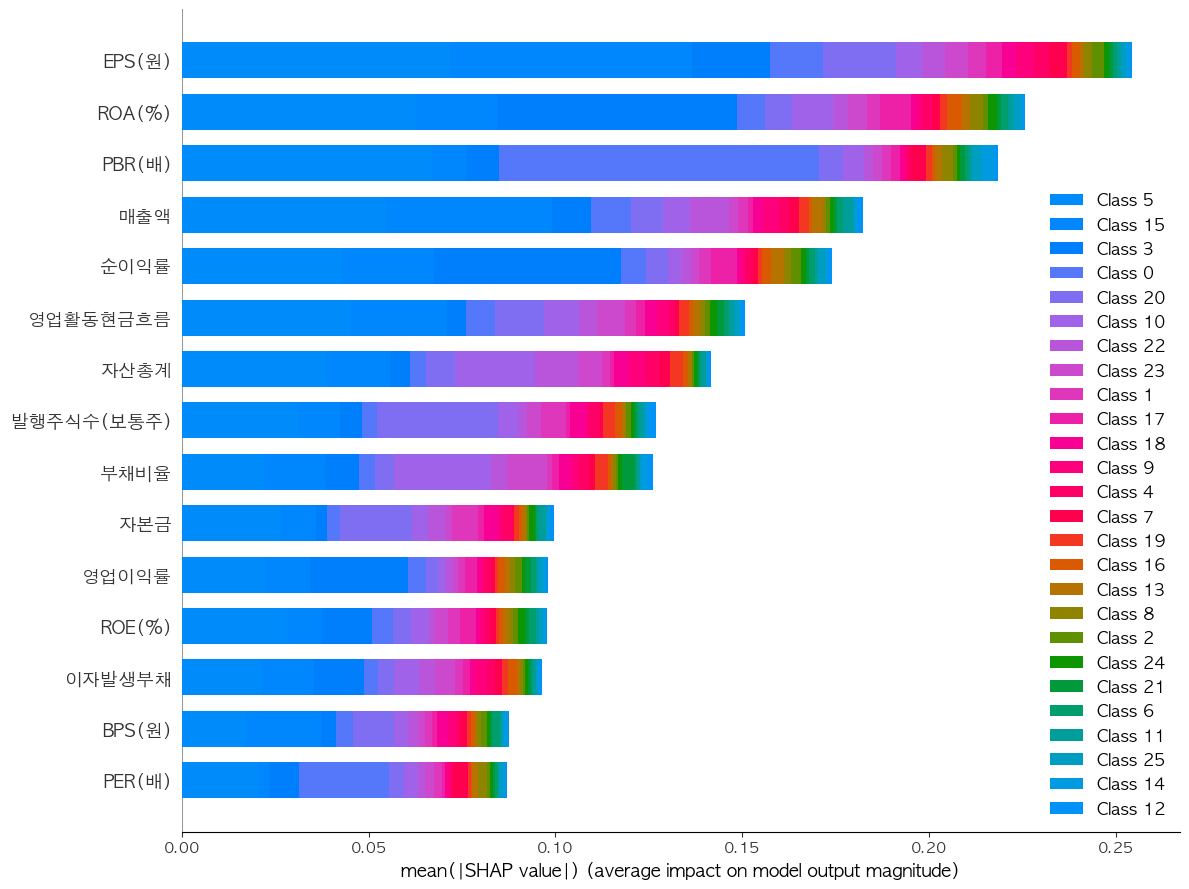

실제 사용된 클러스터 수: 26


In [13]:
best_method = min(dbi_dict, key=lambda k: dbi_dict[k][1])
best_k_method = dbi_dict[best_method][0]
best_dbi_value = dbi_dict[best_method][1]


if best_method == 'KMeans':
    final_labels_2020_2022 = labels_kmeans_all[best_k_method]
elif best_method == 'GMM':
    final_labels_2020_2022 = labels_gmm_all[best_k_method]
elif best_method == 'Spectral':
    final_labels_2020_2022 = labels_spectral_all[best_k_method]


# 데이터에 라벨 부착
df_2020_2022['Cluster'] = final_labels_2020_2022

# ✅ RandomForest 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled_df_2020_2022, final_labels_2020_2022)

# ✅ SHAP 분석
explainer = shap.TreeExplainer(clf)
shap_values_2020_2022 = explainer.shap_values(X_scaled_df_2020_2022)

# ✅ summary plot
shap.summary_plot(shap_values_2020_2022, X_scaled_df_2020_2022, plot_type="bar", show=False)
plt.gcf().set_size_inches(12, 9)
plt.tight_layout()
plt.show()

# ✅ 확인: 실제 클러스터 수
print("실제 사용된 클러스터 수:", len(np.unique(final_labels_2020_2022)))


### 각 클러스터 별, 클러스터 형성에 큰 영향을 미쳤던 Feature

In [14]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2020_2022 = {}
unique_clusters_2020_2022 = np.unique(final_labels_2020_2022)

for cluster_id in unique_clusters_2020_2022:
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(final_labels_2020_2022 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2020_2022[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_scaled_df_2020_2022.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2020_2022[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_scaled_df_2020_2022.columns)

# 각 클래스별 중요도 추가
for cluster_id in unique_clusters_2020_2022:
    shap_arr = cluster_shap_means_2020_2022[cluster_id]
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(shap_arr) != len(X_scaled_df_2020_2022.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(shap_arr)})가 특성 수({len(X_scaled_df_2020_2022.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = shap_arr

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
display(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in unique_clusters_2020_2022:
    col = f'Class {cluster_id}'
    if col not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    sorted_feats = feature_importance_df[col].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(sorted_feats.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):


,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,...,Class 16,Class 17,Class 18,Class 19,Class 20,Class 21,Class 22,Class 23,Class 24,Class 25
매출액,0.037998,0.005006,0.002017,0.006755,0.010786,0.006428,0.021280,0.005847,0.020048,0.010413,...,0.012036,0.005015,0.010767,0.009508,0.007946,0.001409,0.011764,0.008710,0.002790,0.016828
자산총계,0.019961,0.000250,0.000225,0.002032,0.006762,0.002046,0.002512,0.023855,0.000706,0.003175,...,0.002080,0.001726,0.005357,0.005511,0.002820,0.002691,0.002271,0.007232,0.000347,0.009890
자본금,0.013680,0.008617,0.002270,0.001952,0.003593,0.001733,0.000225,0.003534,0.002679,0.003140,...,0.002348,0.010666,0.004853,0.003265,0.005127,0.000875,0.002040,0.002762,0.001137,0.000833
영업활동현금흐름,0.031038,0.011333,0.004609,0.003009,0.008128,0.004148,0.006515,0.004669,0.003842,0.009427,...,0.007250,0.005427,0.007953,0.007772,0.010975,0.013287,0.006792,0.011027,0.013313,0.002025
이자발생부채,0.014447,0.003693,0.000876,0.002251,0.006360,0.001690,0.001592,0.009529,0.021452,0.003475,...,0.001620,0.003045,0.002596,0.005293,0.002560,0.002901,0.003933,0.003449,0.000190,0.008434
영업이익률,0.012976,0.001963,0.000673,0.004961,0.002406,0.003891,0.001648,0.001989,0.020355,0.002444,...,0.003741,0.009105,0.001169,0.001054,0.004100,0.008003,0.002452,0.003790,0.000505,0.022691
순이익률,0.017621,0.002513,0.000192,0.007993,0.002279,0.005442,0.003687,0.001832,0.037989,0.003258,...,0.008800,0.013602,0.002284,0.001387,0.007319,0.000352,0.002983,0.002321,0.003498,0.032067
ROE(%),0.021367,0.004993,0.002384,0.006725,0.000766,0.003139,0.007550,0.009309,0.033147,0.002171,...,0.006109,0.016030,0.000717,0.000308,0.004104,0.005887,0.002415,0.002058,0.004547,0.045978
ROA(%),0.028599,0.001605,0.005307,0.013234,0.002593,0.002807,0.003003,0.005842,0.106896,0.002805,...,0.012321,0.031915,0.000307,0.000727,0.003087,0.001259,0.002695,0.001641,0.003764,0.071009
부채비율,0.018540,0.000942,0.002656,0.002854,0.006501,0.001805,0.005027,0.006093,0.000927,0.001932,...,0.007140,0.005011,0.004176,0.003685,0.002685,0.004010,0.002310,0.005717,0.005565,0.009059



Class 0에 중요한 특성 순위:
1. PBR(배): 0.370296
2. PER(배): 0.102325
3. EPS(원): 0.051958
4. 매출액: 0.037998
5. 영업활동현금흐름: 0.031038
6. ROA(%): 0.028599
7. BPS(원): 0.022432
8. ROE(%): 0.021367
9. 자산총계: 0.019961
10. 부채비율: 0.018540
11. 순이익률: 0.017621
12. 발행주식수(보통주): 0.016409
13. 이자발생부채: 0.014447
14. 자본금: 0.013680
15. 영업이익률: 0.012976

Class 1에 중요한 특성 순위:
1. PBR(배): 0.049073
2. 발행주식수(보통주): 0.012083
3. 영업활동현금흐름: 0.011333
4. EPS(원): 0.011202
5. PER(배): 0.009666
6. 자본금: 0.008617
7. 매출액: 0.005006
8. ROE(%): 0.004993
9. 이자발생부채: 0.003693
10. BPS(원): 0.002606
11. 순이익률: 0.002513
12. 영업이익률: 0.001963
13. ROA(%): 0.001605
14. 부채비율: 0.000942
15. 자산총계: 0.000250

Class 2에 중요한 특성 순위:
1. PBR(배): 0.047153
2. EPS(원): 0.016840
3. PER(배): 0.012610
4. ROA(%): 0.005307
5. BPS(원): 0.004641
6. 영업활동현금흐름: 0.004609
7. 부채비율: 0.002656
8. ROE(%): 0.002384
9. 자본금: 0.002270
10. 매출액: 0.002017
11. 발행주식수(보통주): 0.001990
12. 이자발생부채: 0.000876
13. 영업이익률: 0.000673
14. 자산총계: 0.000225
15. 순이익률: 0.000192

Class 3에 중요한 특성 순위:
1. PBR(배): 0.044652

### 각 클러스터 별 편입 종목 확인

In [15]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in unique_clusters_2020_2022:
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company_2020_2022[final_labels_2020_2022 == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
LG에너지솔루션, SK아이이테크놀로지, 두산퓨얼셀, 삼성바이오로직스, 셀트리온, 씨에스윈드, 엘앤에프, 일진하이솔루스, 카카오페이, 코스모신소재, 포스코퓨처엠, 하이브, 한미사이언스, 한미약품, 한전기술, 호텔신라, 후성
[클러스터 1에 속한 종목들]:
LG디스플레이, 두산에너빌리티, 삼성중공업
[클러스터 2에 속한 종목들]:
태광산업
[클러스터 3에 속한 종목들]:
KT&G, LG, OCI홀딩스, PI첨단소재, SK케미칼, 금호석유화학, 덴티움, 동서, 롯데정밀화학, 미스토홀딩스, 미원상사, 삼성전기, 삼양식품, 엔씨소프트, 영원무역, 영원무역홀딩스, 오리온, 코웨이, 크래프톤, 한미반도체, 한솔케미칼
[클러스터 4에 속한 종목들]:
KB금융, 신한지주
[클러스터 5에 속한 종목들]:
BGF리테일, CJ대한통운, DL, DL이앤씨, GS건설, GS리테일, HD한국조선해양, HD현대미포, HD현대인프라코어, HD현대일렉트릭, HL만도, KCC, LIG넥스원, LS ELECTRIC, SKC, SK네트웍스, SK스퀘어, TCC스틸, TKG휴켐스, 강원랜드, 넷마블, 녹십자, 녹십자홀딩스, 농심, 대상, 대웅, 대웅제약, 대한유화, 대한전선, 더블유게임즈, 동원시스템즈, 두산, 두산밥캣, 롯데쇼핑, 롯데웰푸드, 롯데지주, 롯데칠성, 삼성카드, 삼아알미늄, 세방전지, 세아베스틸지주, 아모레퍼시픽, 아모레퍼시픽홀딩스, 에스엘, 에스원, 오리온홀딩스, 유한양행, 율촌화학, 제일기획, 종근당, 코스맥스, 코스모화학, 코오롱인더, 포스코DX, 풍산, 하이트진로, 한국앤컴퍼니, 한국콜마, 한국타이어앤테크놀로지, 한국항공우주, 한샘, 한세실업, 한일시멘트, 한전KPS, 한화솔루션, 한화시스템, 한화에어로스페이스, 현대건설, 현대로템, 현대백화점, 현대엘리베이터, 현대위아, 효성중공업
[클러스터 6에 속한 종목들]:
GKL
[클러스터 7에 속한 종목들]:
HS효성첨단소재, 한올바이오파마
[클러스터 8에 속한 종목들]:
SK바이오팜
[클러스터 9에 

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

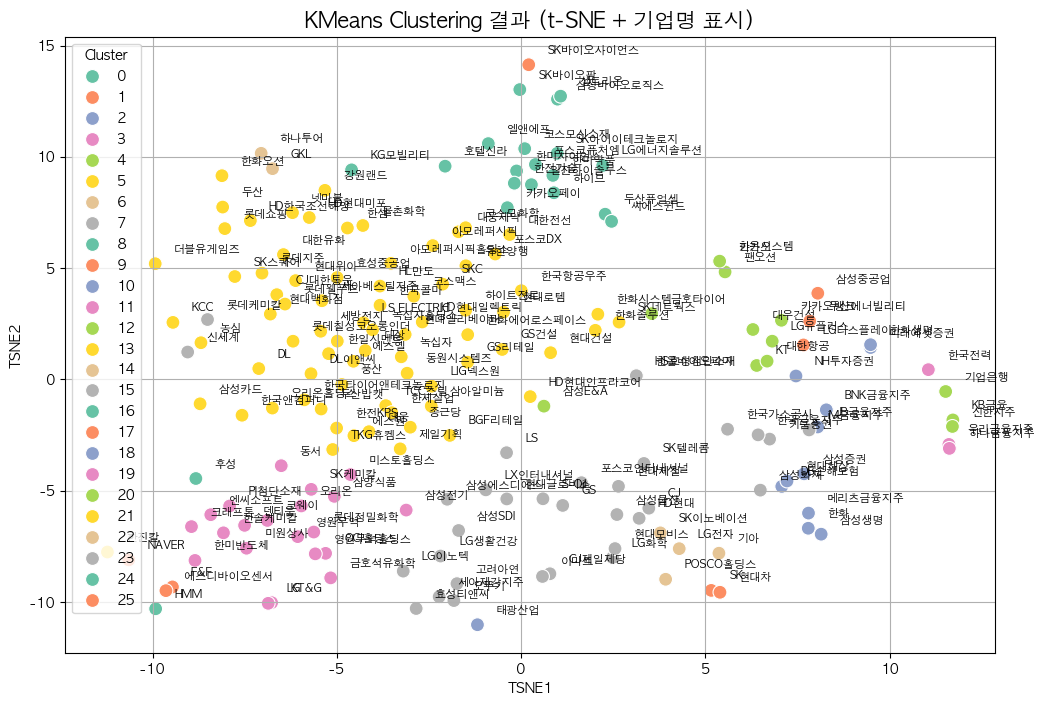

In [16]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled_df_2020_2022)

# 결과 DataFrame 생성
df_clustered = pd.DataFrame({
    '기업명': company_2020_2022.values,
    'Cluster': final_labels_2020_2022,  # ✅ 자동 선택된 클러스터 라벨 사용
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', s=100)

# 기업명 라벨 추가
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['TSNE1'][i]+0.5, df_clustered['TSNE2'][i]+0.5, df_clustered['기업명'][i], fontsize=8)

# 제목 및 스타일
plt.title(f"{best_method} Clustering 결과 (t-SNE + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2021-2023)

Best K for KMeans (lowest DBI): 30 -> DBI = 0.8024
Best K for GMM (lowest DBI): 30 -> DBI = 0.8020
Best K for Spectral Clustering (lowest DBI): 24 -> DBI = 1.3787


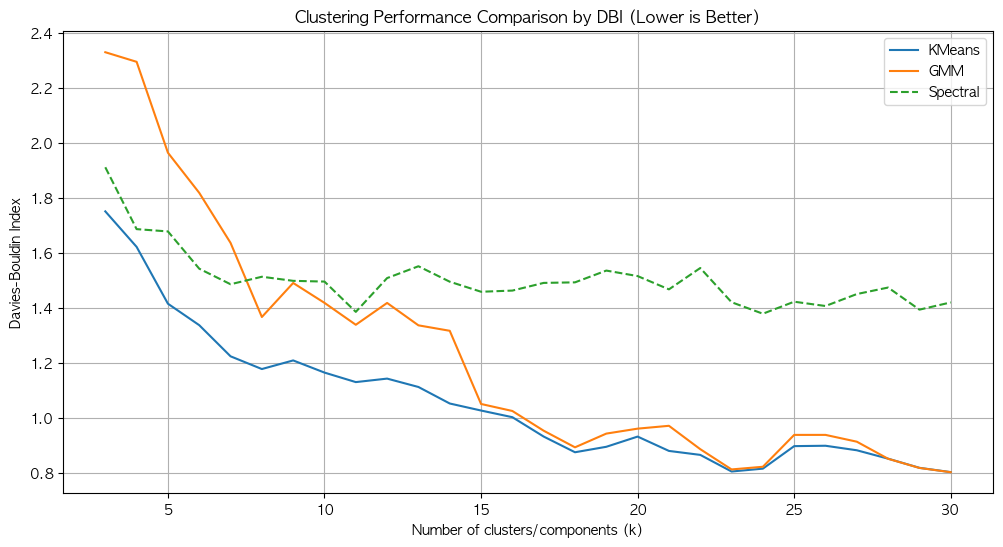

In [17]:
# 결과 저장
k_range = range(3, 31)

dbi_kmeans, dbi_gmm, dbi_spectral = [], [], []

labels_kmeans_all, labels_gmm_all, labels_spectral_all = {}, {}, {}

# 반복 수행
for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels_2021_2023 = kmeans.fit_predict(X_scaled_2021_2023)
    dbi_kmeans.append(davies_bouldin_score(X_scaled_df_2021_2023, kmeans_labels_2021_2023))
    labels_kmeans_all[k] = kmeans_labels_2021_2023

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2021_2023 = gmm.fit_predict(X_scaled_df_2021_2023)
    dbi_gmm.append(davies_bouldin_score(X_scaled_df_2021_2023, gmm_labels_2021_2023))
    labels_gmm_all[k] = gmm_labels_2021_2023

    # Spectral Clustering
    try:
        spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
        spectral_labels_2021_2023 = spectral.fit_predict(X_scaled_df_2021_2023)
        dbi_spectral.append(davies_bouldin_score(X_scaled_df_2021_2023, spectral_labels_2021_2023))
        labels_spectral_all[k] = spectral_labels_2021_2023

    except Exception:
        # 실패한 경우 큰 값으로 대체 (e.g., affinity 문제 등)
        dbi_spectral.append(np.inf)
        labels_spectral_all[k] = None


# 가장 낮은 DBI를 보이는 k 찾기
best_k_kmeans = k_range[np.argmin(dbi_kmeans)]
best_k_gmm = k_range[np.argmin(dbi_gmm)]
best_k_spectral = k_range[np.argmin(dbi_spectral)]

min_dbi_kmeans = min(dbi_kmeans)
min_dbi_gmm = min(dbi_gmm)
min_dbi_spectral = min(dbi_spectral)

# 3. 세 값 비교해서 최소값 및 방법 선택
dbi_dict = {
    'KMeans': (best_k_kmeans, min_dbi_kmeans),
    'GMM': (best_k_gmm, min_dbi_gmm),
    'Spectral': (best_k_spectral, min_dbi_spectral)
}

# 결과 출력
print(f"Best K for KMeans (lowest DBI): {best_k_kmeans} -> DBI = {min_dbi_kmeans:.4f}")
print(f"Best K for GMM (lowest DBI): {best_k_gmm} -> DBI = {min_dbi_gmm:.4f}")
print(f"Best K for Spectral Clustering (lowest DBI): {best_k_spectral} -> DBI = {min_dbi_spectral:.4f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, dbi_kmeans, label='KMeans')
plt.plot(k_range, dbi_gmm, label='GMM')
plt.plot(k_range, dbi_spectral, label='Spectral', linestyle='--')
plt.xlabel('Number of clusters/components (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Clustering Performance Comparison by DBI (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


### SHAP 분석

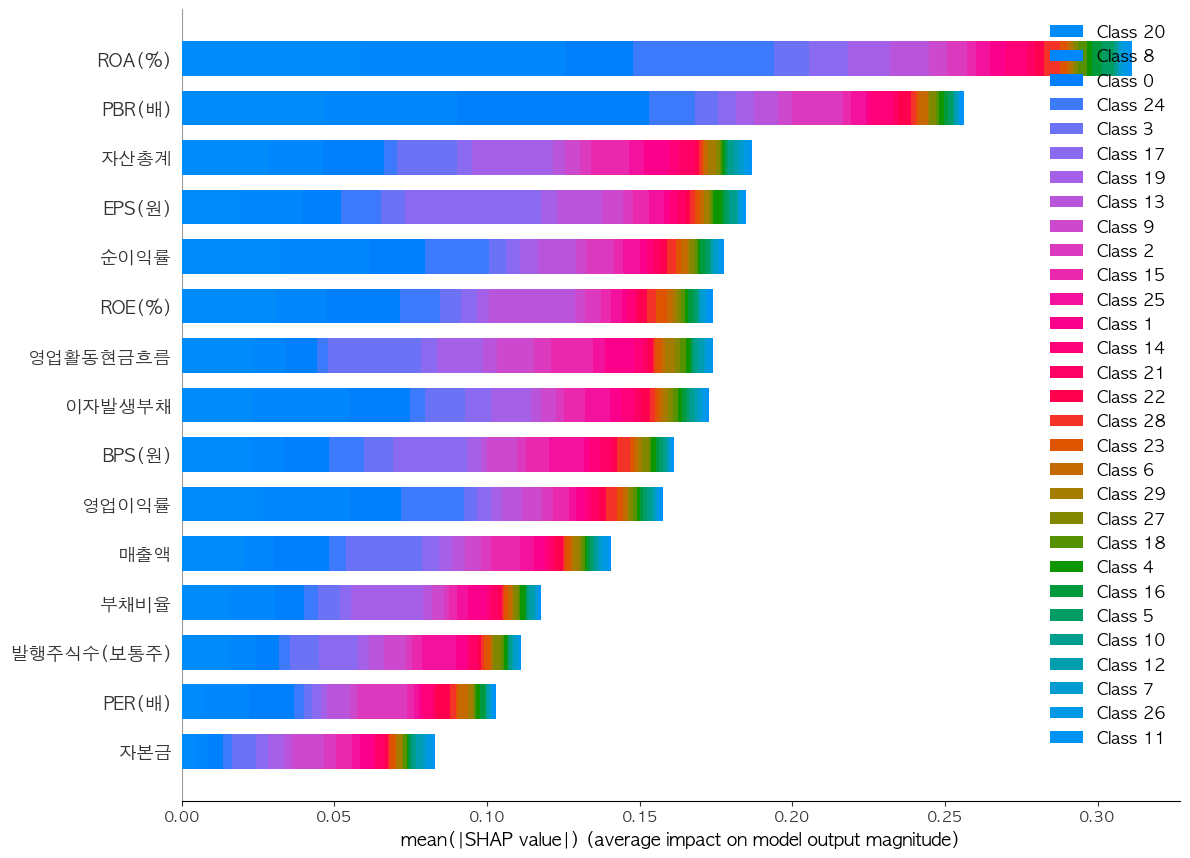

실제 사용된 클러스터 수: 30


In [18]:
best_method = min(dbi_dict, key=lambda k: dbi_dict[k][1])
best_k_method = dbi_dict[best_method][0]
best_dbi_value = dbi_dict[best_method][1]


if best_method == 'KMeans':
    final_labels_2021_2023 = labels_kmeans_all[best_k_method]
elif best_method == 'GMM':
    final_labels_2021_2023 = labels_gmm_all[best_k_method]
elif best_method == 'Spectral':
    final_labels_2021_2023 = labels_spectral_all[best_k_method]


# 데이터에 라벨 부착
df_2021_2023['Cluster'] = final_labels_2021_2023

# ✅ RandomForest 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled_df_2021_2023, final_labels_2021_2023)

# ✅ SHAP 분석
explainer = shap.TreeExplainer(clf)
shap_values_2021_2023 = explainer.shap_values(X_scaled_df_2021_2023)

# ✅ summary plot
shap.summary_plot(shap_values_2021_2023, X_scaled_df_2021_2023, plot_type="bar", show=False)
plt.gcf().set_size_inches(12, 9)
plt.tight_layout()
plt.show()

# ✅ 확인: 실제 클러스터 수
print("실제 사용된 클러스터 수:", len(np.unique(final_labels_2021_2023)))


### 각 클러스터 별, 클러스터 형성에 큰 영향을 미쳤던 Feature

In [19]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2021_2023 = {}
unique_clusters_2021_2023 = np.unique(final_labels_2021_2023)

for cluster_id in unique_clusters_2021_2023:
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(final_labels_2021_2023 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2021_2023[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_scaled_df_2021_2023.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2021_2023[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_scaled_df_2021_2023.columns)

# 각 클래스별 중요도 추가
for cluster_id in unique_clusters_2021_2023:
    shap_arr = cluster_shap_means_2021_2023[cluster_id]
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(shap_arr) != len(X_scaled_df_2021_2023.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(shap_arr)})가 특성 수({len(X_scaled_df_2021_2023.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = shap_arr

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
display(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in unique_clusters_2021_2023:
    col = f'Class {cluster_id}'
    if col not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    sorted_feats = feature_importance_df[col].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(sorted_feats.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):


,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,...,Class 20,Class 21,Class 22,Class 23,Class 24,Class 25,Class 26,Class 27,Class 28,Class 29
매출액,0.041171,0.020613,0.012602,0.025828,0.016467,0.006685,0.012035,0.017332,0.014408,0.016754,...,0.014908,0.017425,0.012255,0.005977,0.010902,0.009950,0.019472,0.009096,0.011868,0.019576
자산총계,0.045758,0.029664,0.015988,0.026273,0.000652,0.011847,0.020389,0.021468,0.012229,0.022298,...,0.009845,0.031582,0.010424,0.013807,0.011710,0.009291,0.022364,0.009694,0.014848,0.022892
자본금,0.012152,0.001491,0.011106,0.002478,0.001685,0.006766,0.004883,0.001779,0.004143,0.005677,...,0.003350,0.004093,0.005242,0.000773,0.002747,0.002155,0.001814,0.003388,0.003737,0.001950
영업활동현금흐름,0.030640,0.011966,0.005427,0.017599,0.006490,0.003722,0.011266,0.004886,0.004351,0.018178,...,0.004151,0.010905,0.009321,0.010391,0.005015,0.005140,0.018044,0.015354,0.000483,0.011981
이자발생부채,0.045795,0.020493,0.013071,0.022632,0.016502,0.004729,0.012364,0.019629,0.011911,0.022790,...,0.016835,0.032881,0.010195,0.014192,0.010815,0.019483,0.016494,0.024868,0.007180,0.019744
영업이익률,0.042396,0.006612,0.007736,0.008356,0.010174,0.057366,0.011727,0.003928,0.017087,0.012048,...,0.010114,0.008413,0.016185,0.004117,0.035199,0.007863,0.002357,0.007727,0.055346,0.006228
순이익률,0.048918,0.007763,0.035410,0.009397,0.011627,0.036358,0.047125,0.009180,0.011891,0.012226,...,0.010721,0.003685,0.038734,0.019337,0.018097,0.016250,0.010736,0.001520,0.027998,0.003065
ROE(%),0.057259,0.004776,0.043615,0.011965,0.014884,0.011648,0.067499,0.023685,0.009437,0.014062,...,0.017893,0.006146,0.056641,0.048851,0.014822,0.030005,0.015678,0.027075,0.020220,0.011380
ROA(%),0.055357,0.003414,0.008003,0.009731,0.009929,0.105581,0.011668,0.004823,0.015346,0.010436,...,0.008350,0.001850,0.010779,0.017528,0.066017,0.009583,0.010809,0.004704,0.084973,0.002721
부채비율,0.023219,0.003323,0.007036,0.005053,0.010366,0.012118,0.015815,0.006130,0.010491,0.004880,...,0.007126,0.003111,0.011939,0.004594,0.008389,0.007971,0.000436,0.006967,0.008540,0.005185



Class 0에 중요한 특성 순위:
1. PBR(배): 0.140936
2. ROE(%): 0.057259
3. ROA(%): 0.055357
4. PER(배): 0.049459
5. 순이익률: 0.048918
6. 이자발생부채: 0.045795
7. 자산총계: 0.045758
8. 영업이익률: 0.042396
9. 매출액: 0.041171
10. EPS(원): 0.036713
11. BPS(원): 0.035772
12. 영업활동현금흐름: 0.030640
13. 부채비율: 0.023219
14. 발행주식수(보통주): 0.019824
15. 자본금: 0.012152

Class 1에 중요한 특성 순위:
1. PBR(배): 0.036411
2. 자산총계: 0.029664
3. 매출액: 0.020613
4. 이자발생부채: 0.020493
5. 영업활동현금흐름: 0.011966
6. 발행주식수(보통주): 0.008586
7. 순이익률: 0.007763
8. 영업이익률: 0.006612
9. ROE(%): 0.004776
10. PER(배): 0.003870
11. ROA(%): 0.003414
12. 부채비율: 0.003323
13. BPS(원): 0.003086
14. EPS(원): 0.002338
15. 자본금: 0.001491

Class 2에 중요한 특성 순위:
1. PBR(배): 0.059355
2. PER(배): 0.047967
3. ROE(%): 0.043615
4. 순이익률: 0.035410
5. 자산총계: 0.015988
6. 이자발생부채: 0.013071
7. 매출액: 0.012602
8. BPS(원): 0.012170
9. 자본금: 0.011106
10. EPS(원): 0.008729
11. ROA(%): 0.008003
12. 영업이익률: 0.007736
13. 부채비율: 0.007036
14. 영업활동현금흐름: 0.005427
15. 발행주식수(보통주): 0.004326

Class 3에 중요한 특성 순위:
1. PBR(배): 0.047895

### 각 클러스터 별 편입 종목 확인

In [20]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in unique_clusters_2021_2023:
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company_2021_2023[final_labels_2021_2023 == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
BGF리테일, HD현대일렉트릭, KG모빌리티, LIG넥스원, PI첨단소재, SK바이오사이언스, SK아이이테크놀로지, TCC스틸, 대웅제약, 대한전선, 동원시스템즈, 유한양행, 코스맥스, 하이브, 한국항공우주, 한미사이언스, 한미약품, 한전기술, 한화에어로스페이스, 현대로템, 현대엘리베이터, 호텔신라, 후성
[클러스터 1에 속한 종목들]:
KB금융, 신한지주, 우리금융지주, 하나금융지주
[클러스터 2에 속한 종목들]:
HD현대중공업, 두산퓨얼셀, 삼아알미늄, 씨에스윈드, 일진하이솔루스, 포스코퓨처엠
[클러스터 3에 속한 종목들]:
CJ, DB손해보험, GS, HD현대, KT, LG에너지솔루션, S-Oil, SK텔레콤, 삼성물산, 포스코인터내셔널, 현대글로비스, 현대제철, 현대해상
[클러스터 4에 속한 종목들]:
태광산업
[클러스터 5에 속한 종목들]:
한미반도체
[클러스터 6에 속한 종목들]:
에코프로머티
[클러스터 7에 속한 종목들]:
한국전력
[클러스터 8에 속한 종목들]:
HD현대인프라코어, KT&G, LG, LX인터내셔널, SK케미칼, TKG휴켐스, 강원랜드, 대웅, 더블유게임즈, 동서, 두산밥캣, 롯데정밀화학, 미스토홀딩스, 삼성E&A, 삼성에스디에스, 삼성전기, 삼성카드, 세방전지, 에스엘, 에스원, 엔씨소프트, 오리온홀딩스, 제일기획, 풍산, 한국앤컴퍼니, 한국타이어앤테크놀로지, 한세실업, 한일시멘트, 한전KPS
[클러스터 9에 속한 종목들]:
LG유플러스, NH투자증권, 대우건설, 대한항공, 두산에너빌리티, 카카오뱅크
[클러스터 10에 속한 종목들]:
현대차
[클러스터 11에 속한 종목들]:
하나투어
[클러스터 12에 속한 종목들]:
기업은행
[클러스터 13에 속한 종목들]:
GKL, HD현대미포, SKC, 넷마블, 대한유화, 두산, 엘앤에프, 율촌화학, 코스모화학, 한샘
[클러스터 14에 속한 종목들]:
SK바이오팜, 코스모신소재, 포스코DX
[클러스터 15에 속한 종목들]:
LG전자, LG화학, POSCO홀딩스,

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

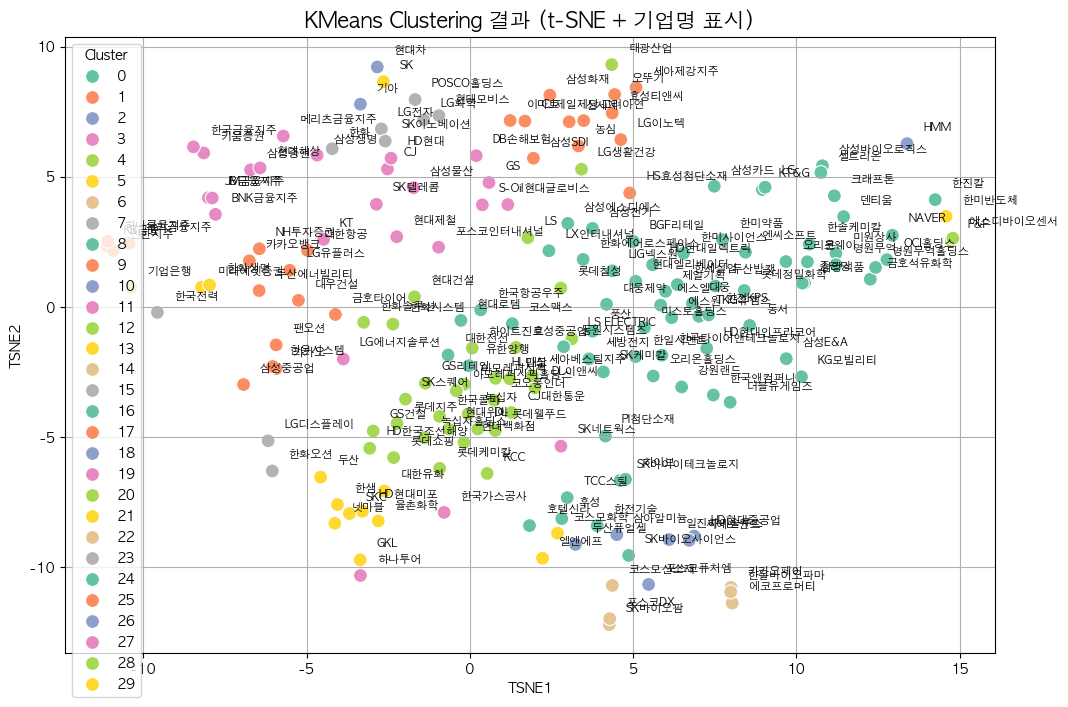

In [21]:
# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled_df_2021_2023)

# 결과 DataFrame 생성
df_clustered = pd.DataFrame({
    '기업명': company_2021_2023.values,
    'Cluster': final_labels_2021_2023,
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', s=100)

# 기업명 라벨 추가
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['TSNE1'][i]+0.5, df_clustered['TSNE2'][i]+0.5, df_clustered['기업명'][i], fontsize=8)

# 제목 및 스타일
plt.title("KMeans Clustering 결과 (t-SNE + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

### 최적의 K 찾기 (2022-2024) - 자동화

Best K for KMeans (lowest DBI): 14 -> DBI = 0.8381
Best K for GMM (lowest DBI): 20 -> DBI = 0.8536
Best K for Spectral Clustering (lowest DBI): 12 -> DBI = 1.3708


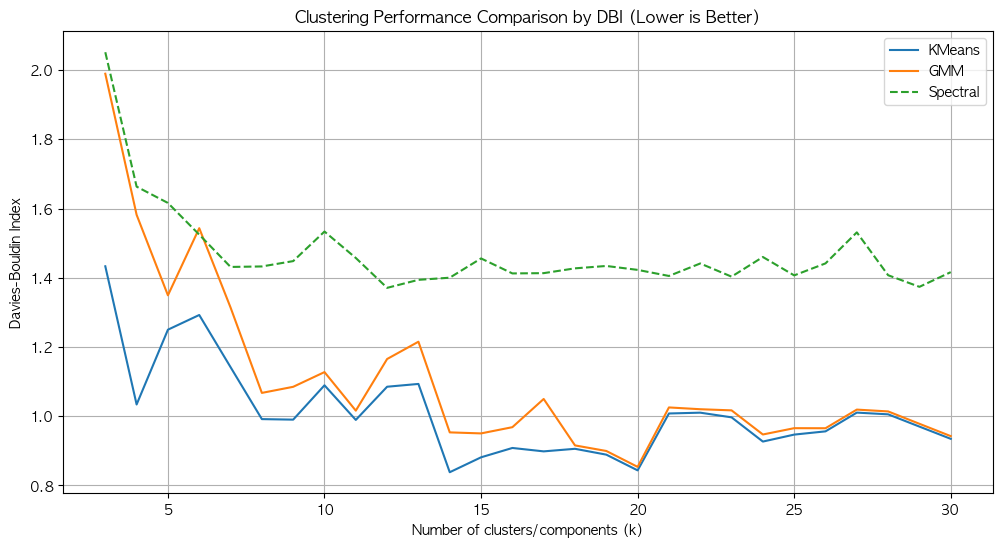

In [22]:
# 결과 저장
k_range = range(3, 31)

dbi_kmeans, dbi_gmm, dbi_spectral = [], [], []

labels_kmeans_all, labels_gmm_all, labels_spectral_all = {}, {}, {}

# 반복 수행
for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_labels_2022_2024 = kmeans.fit_predict(X_scaled_2022_2024)
    dbi_kmeans.append(davies_bouldin_score(X_scaled_df_2022_2024, kmeans_labels_2022_2024))
    labels_kmeans_all[k] = kmeans_labels_2022_2024

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels_2022_2024 = gmm.fit_predict(X_scaled_df_2022_2024)
    dbi_gmm.append(davies_bouldin_score(X_scaled_df_2022_2024, gmm_labels_2022_2024))
    labels_gmm_all[k] = gmm_labels_2022_2024

    # Spectral Clustering
    try:
        spectral = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', assign_labels='kmeans')
        spectral_labels_2022_2024 = spectral.fit_predict(X_scaled_df_2022_2024)
        dbi_spectral.append(davies_bouldin_score(X_scaled_df_2022_2024, spectral_labels_2022_2024))
        labels_spectral_all[k] = spectral_labels_2022_2024

    except Exception:
        # 실패한 경우 큰 값으로 대체 (e.g., affinity 문제 등)
        dbi_spectral.append(np.inf)
        labels_spectral_all[k] = None


# 가장 낮은 DBI를 보이는 k 찾기
best_k_kmeans = k_range[np.argmin(dbi_kmeans)]
best_k_gmm = k_range[np.argmin(dbi_gmm)]
best_k_spectral = k_range[np.argmin(dbi_spectral)]

min_dbi_kmeans = min(dbi_kmeans)
min_dbi_gmm = min(dbi_gmm)
min_dbi_spectral = min(dbi_spectral)

# 3. 세 값 비교해서 최소값 및 방법 선택
dbi_dict = {
    'KMeans': (best_k_kmeans, min_dbi_kmeans),
    'GMM': (best_k_gmm, min_dbi_gmm),
    'Spectral': (best_k_spectral, min_dbi_spectral)
}

# 결과 출력
print(f"Best K for KMeans (lowest DBI): {best_k_kmeans} -> DBI = {min_dbi_kmeans:.4f}")
print(f"Best K for GMM (lowest DBI): {best_k_gmm} -> DBI = {min_dbi_gmm:.4f}")
print(f"Best K for Spectral Clustering (lowest DBI): {best_k_spectral} -> DBI = {min_dbi_spectral:.4f}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(k_range, dbi_kmeans, label='KMeans')
plt.plot(k_range, dbi_gmm, label='GMM')
plt.plot(k_range, dbi_spectral, label='Spectral', linestyle='--')
plt.xlabel('Number of clusters/components (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Clustering Performance Comparison by DBI (Lower is Better)')
plt.legend()
plt.grid(True)
plt.show()


### SHAP 분석

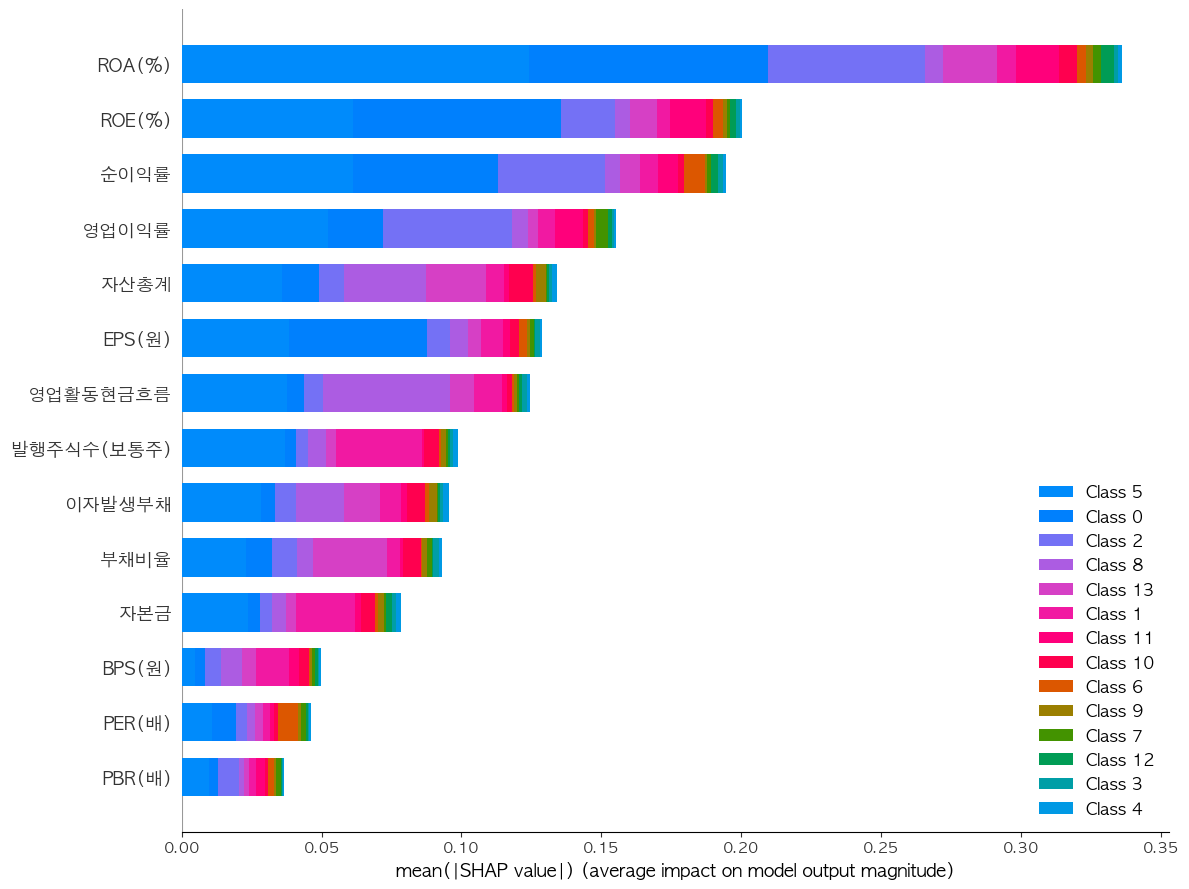

실제 사용된 클러스터 수: 14


In [23]:
best_method = min(dbi_dict, key=lambda k: dbi_dict[k][1])
best_k_method = dbi_dict[best_method][0]
best_dbi_value = dbi_dict[best_method][1]


if best_method == 'KMeans':
    final_labels_2022_2024 = labels_kmeans_all[best_k_method]
elif best_method == 'GMM':
    final_labels_2022_2024 = labels_gmm_all[best_k_method]
elif best_method == 'Spectral':
    final_labels_2022_2024 = labels_spectral_all[best_k_method]


# 데이터에 라벨 부착
df_2022_2024['Cluster'] = final_labels_2022_2024

# ✅ RandomForest 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled_df_2022_2024, final_labels_2022_2024)

# ✅ SHAP 분석
explainer = shap.TreeExplainer(clf)
shap_values_2022_2024 = explainer.shap_values(X_scaled_df_2022_2024)

# ✅ summary plot
shap.summary_plot(shap_values_2022_2024, X_scaled_df_2022_2024, plot_type="bar", show=False)
plt.gcf().set_size_inches(12, 9)
plt.tight_layout()
plt.show()

# ✅ 확인: 실제 클러스터 수
print("실제 사용된 클러스터 수:", len(np.unique(final_labels_2022_2024)))


### 각 클러스터 별, 클러스터 형성에 큰 영향을 미쳤던 Feature

In [24]:
# 클러스터별 SHAP 값의 평균 구하기
cluster_shap_means_2022_2024 = {}
unique_clusters_2022_2024 = np.unique(final_labels_2022_2024)

for cluster_id in unique_clusters_2022_2024:
    # 현재 클러스터에 속한 인덱스 추출
    cluster_indices = np.where(final_labels_2022_2024 == cluster_id)[0]
    
    # 해당 클러스터에 대한 SHAP 값만 선택
    cluster_shap_values = shap_values_2022_2024[cluster_indices]
    
    # SHAP 값의 절대값 평균 계산
    cluster_mean_shap = np.abs(cluster_shap_values).mean(axis=0)
    
    # 2차원 배열인 경우 1차원으로 변환 (첫 번째 차원만 사용하거나 적절히 처리)
    if len(cluster_mean_shap.shape) > 1:
        # 차원이 (14, 4)와 같이 2차원인 경우, 첫 번째 차원만 사용하거나 평탄화
        cluster_mean_shap = cluster_mean_shap.flatten() if cluster_mean_shap.size == len(X_scaled_df_2022_2024.columns) else cluster_mean_shap[:, 0]
    
    # 결과 저장
    cluster_shap_means_2022_2024[cluster_id] = cluster_mean_shap

# 모든 클래스에 대한 특성 중요도를 DataFrame으로 변환
feature_importance_df = pd.DataFrame(index=X_scaled_df_2022_2024.columns)

# 각 클래스별 중요도 추가
for cluster_id in unique_clusters_2022_2024:
    shap_arr = cluster_shap_means_2022_2024[cluster_id]
    # cluster_shap_means[cluster_id]의 길이가 X_raw.columns와 일치하는지 확인
    if len(shap_arr) != len(X_scaled_df_2022_2024.columns):
        print(f"경고: 클러스터 {cluster_id}의 SHAP 값 길이({len(shap_arr)})가 특성 수({len(X_scaled_df_2022_2024.columns)})와 일치하지 않습니다.")
        continue
    
    feature_importance_df[f'Class {cluster_id}'] = shap_arr

# 결과 출력 - 각 클래스별로 내림차순 정렬해서 보여주기
print("각 클래스별 특성 중요도 (SHAP 값 평균):")
display(feature_importance_df)

# 각 클래스별로 중요 특성 순위 확인
for cluster_id in unique_clusters_2022_2024:
    col = f'Class {cluster_id}'
    if col not in feature_importance_df.columns:
        print(f"\nClass {cluster_id}에 대한 특성 중요도를 계산할 수 없습니다.")
        continue
        
    print(f"\nClass {cluster_id}에 중요한 특성 순위:")
    sorted_feats = feature_importance_df[col].sort_values(ascending=False)
    for i, (feature, importance) in enumerate(sorted_feats.items(), 1):
        print(f"{i}. {feature}: {importance:.6f}")

각 클래스별 특성 중요도 (SHAP 값 평균):


,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,Class 10,Class 11,Class 12,Class 13
자산총계,0.021645,0.012145,0.004284,0.084327,0.051189,0.004787,0.005543,0.005653,0.031207,0.020131,0.051872,0.004122,0.004174,0.038438
자본금,0.011450,0.012547,0.000634,0.054308,0.015447,0.000990,0.005675,0.004423,0.002098,0.002928,0.009361,0.000571,0.000695,0.003767
영업활동현금흐름,0.012119,0.007700,0.001575,0.053947,0.001647,0.002050,0.003881,0.002389,0.025290,0.004322,0.007656,0.001483,0.001574,0.002095
이자발생부채,0.011505,0.002241,0.001260,0.065303,0.021874,0.001164,0.014038,0.001963,0.011135,0.012667,0.021805,0.001563,0.001427,0.005669
영업이익률,0.044751,0.015497,0.015365,0.032108,0.011843,0.012284,0.019195,0.044612,0.014981,0.011511,0.015412,0.015942,0.015355,0.015946
순이익률,0.121075,0.041383,0.036143,0.091533,0.029201,0.034730,0.054568,0.039277,0.034957,0.031952,0.030638,0.035238,0.036366,0.037433
ROE(%),0.183970,0.061429,0.046231,0.098987,0.038272,0.048282,0.077317,0.046414,0.051707,0.035359,0.037456,0.045380,0.045797,0.048455
ROA(%),0.189778,0.061354,0.062620,0.103136,0.055211,0.062215,0.106447,0.072554,0.059281,0.044081,0.051195,0.060279,0.061487,0.047660
부채비율,0.016718,0.017978,0.002552,0.070065,0.036464,0.003028,0.005609,0.010122,0.008750,0.000490,0.034834,0.002323,0.001594,0.035843
EPS(원),0.118984,0.038120,0.033620,0.084423,0.017637,0.033255,0.068138,0.054428,0.034380,0.027346,0.022874,0.032399,0.034986,0.024536



Class 0에 중요한 특성 순위:
1. ROA(%): 0.189778
2. ROE(%): 0.183970
3. 순이익률: 0.121075
4. EPS(원): 0.118984
5. 영업이익률: 0.044751
6. PER(배): 0.024221
7. 자산총계: 0.021645
8. 부채비율: 0.016718
9. 영업활동현금흐름: 0.012119
10. 이자발생부채: 0.011505
11. 자본금: 0.011450
12. 발행주식수(보통주): 0.009147
13. BPS(원): 0.007754
14. PBR(배): 0.006927

Class 1에 중요한 특성 순위:
1. ROE(%): 0.061429
2. ROA(%): 0.061354
3. 순이익률: 0.041383
4. EPS(원): 0.038120
5. 발행주식수(보통주): 0.024455
6. 부채비율: 0.017978
7. 영업이익률: 0.015497
8. 자본금: 0.012547
9. 자산총계: 0.012145
10. BPS(원): 0.009030
11. 영업활동현금흐름: 0.007700
12. PER(배): 0.004149
13. PBR(배): 0.003732
14. 이자발생부채: 0.002241

Class 2에 중요한 특성 순위:
1. ROA(%): 0.062620
2. ROE(%): 0.046231
3. 순이익률: 0.036143
4. EPS(원): 0.033620
5. 영업이익률: 0.015365
6. 자산총계: 0.004284
7. 부채비율: 0.002552
8. PER(배): 0.001928
9. 영업활동현금흐름: 0.001575
10. BPS(원): 0.001450
11. 이자발생부채: 0.001260
12. 발행주식수(보통주): 0.000784
13. PBR(배): 0.000760
14. 자본금: 0.000634

Class 3에 중요한 특성 순위:
1. ROA(%): 0.103136
2. ROE(%): 0.098987
3. 순이익률: 0.091533
4. EPS(원): 0.08

### 각 클러스터 별 편입 종목 확인

In [25]:
# 클러스터별 기업 리스트를 출력한다.
for cluster_id in unique_clusters_2022_2024:
    print(f"[클러스터 {cluster_id}에 속한 종목들]:")
    stock_list = company_2022_2024[final_labels_2022_2024 == cluster_id].values
    print(", ".join(stock_list))


[클러스터 0에 속한 종목들]:
DL, GS건설, GS리테일, HD현대미포, KG모빌리티, LG디스플레이, SKC, SK네트웍스, SK바이오사이언스, SK이노베이션, 넷마블, 녹십자, 녹십자홀딩스, 대한유화, 두산, 두산퓨얼셀, 롯데쇼핑, 롯데지주, 롯데케미칼, 삼아알미늄, 엘앤에프, 율촌화학, 이마트, 일진하이솔루스, 카카오, 코스모화학, 포스코퓨처엠, 한온시스템, 한올바이오파마, 한화솔루션, 한화오션, 현대건설, 현대백화점, 현대제철, 호텔신라, 후성
[클러스터 1에 속한 종목들]:
HMM, LG유플러스, 금호타이어, 대우건설, 대한항공, 두산에너빌리티, 삼성중공업, 카카오뱅크, 팬오션, 한화생명
[클러스터 2에 속한 종목들]:
HD현대일렉트릭, KT&G, SK스퀘어, 강원랜드, 더블유게임즈, 덴티움, 동서, 미원상사, 삼성바이오로직스, 삼양식품, 셀트리온, 영원무역, 영원무역홀딩스, 오리온, 종근당, 코웨이, 크래프톤, 포스코DX, 한국앤컴퍼니, 한미약품, 한솔케미칼, 한전KPS, 한화에어로스페이스
[클러스터 3에 속한 종목들]:
한국전력
[클러스터 4에 속한 종목들]:
기업은행
[클러스터 5에 속한 종목들]:
BGF리테일, CJ대한통운, CJ제일제당, DL이앤씨, GKL, GS, HD한국조선해양, HD현대인프라코어, HD현대중공업, HL만도, HS효성첨단소재, KCC, LG, LG생활건강, LG에너지솔루션, LG이노텍, LIG넥스원, LS, LS ELECTRIC, LX인터내셔널, NAVER, OCI홀딩스, PI첨단소재, S-Oil, SK아이이테크놀로지, SK케미칼, TCC스틸, TKG휴켐스, 고려아연, 금호석유화학, 농심, 대상, 대웅, 대웅제약, 대한전선, 동원시스템즈, 두산밥캣, 롯데웰푸드, 롯데정밀화학, 롯데칠성, 미스토홀딩스, 삼성E&A, 삼성SDI, 삼성물산, 삼성에스디에스, 삼성전기, 삼성카드, 삼성화재, 세방전지, 세아베스틸지주, 세아제강지주, 신세계, 씨에스윈드, 아모레퍼시픽, 아모레퍼시픽홀딩스, 에스엘, 에스원, 엔씨소프트, 오뚜기, 오

### K-means 클러스터링 결과에 종목명을 포함해서 시각화

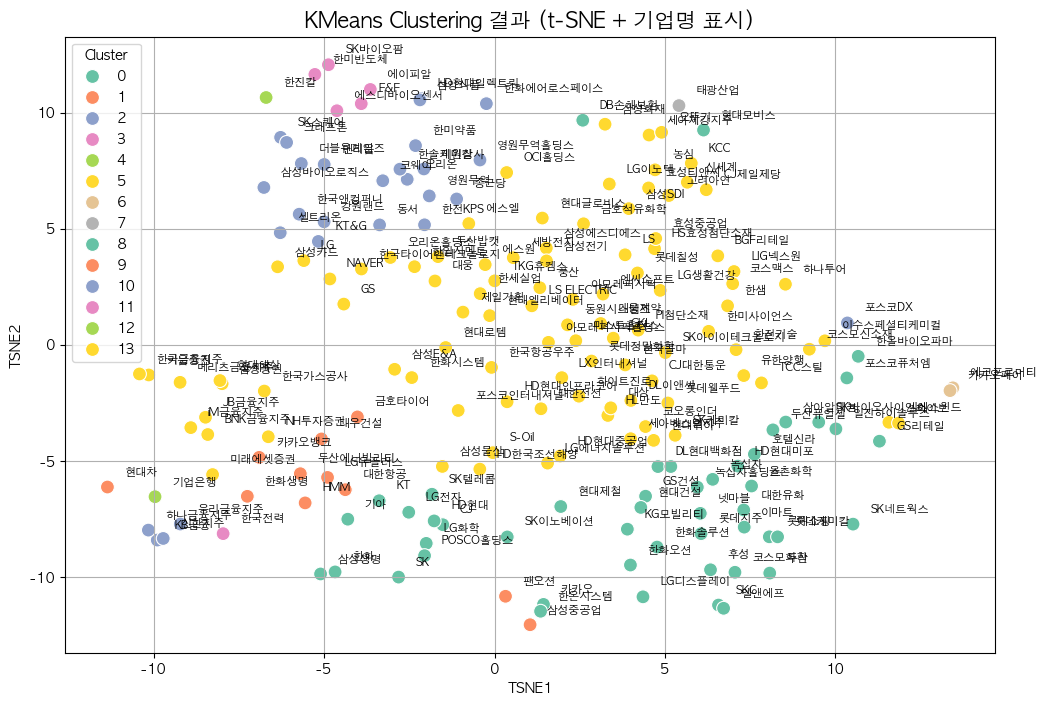

In [26]:
# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled_df_2022_2024)

# 결과 DataFrame 생성
df_clustered = pd.DataFrame({
    '기업명': company_2022_2024.values,
    'Cluster': final_labels_2022_2024,
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1]
})

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clustered, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', s=100)

# 기업명 라벨 추가
for i in range(df_clustered.shape[0]):
    plt.text(df_clustered['TSNE1'][i]+0.5, df_clustered['TSNE2'][i]+0.5, df_clustered['기업명'][i], fontsize=8)

# 제목 및 스타일
plt.title("KMeans Clustering 결과 (t-SNE + 기업명 표시)", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# 포트폴리오 최적화

## Inter Cluster Portfolio vs. Random Sampling Portfolio

## Evaluation Using Sharpe Ratio, Sortino Ratio, and CVaR

### 자산 데이터 수집 및 로그 수익률 변환

In [27]:
#자산들 목록 보기
import FinanceDataReader as fdr
from tqdm import tqdm
import datetime

# 1. 세 윈도우에서 기업명 합집합 만들기
companies_2020_2022 = set(df_2020_2022['기업명_그룹'])
companies_2021_2023 = set(df_2021_2023['기업명_그룹'])
companies_2022_2024 = set(df_2022_2024['기업명_그룹'])

all_companies = companies_2020_2022.union(companies_2021_2023).union(companies_2022_2024)
company_list = sorted(all_companies)

krx_listed = fdr.StockListing('KRX')

# 기업명과 티커 매핑
company_ticker_map = {}
for name in company_list:
    match = krx_listed[krx_listed['Name'] == name]
    if not match.empty:
        code = match.iloc[0]['Code']
        company_ticker_map[name] = code
    else:
        print(f"매칭되지 않은 기업명: {name}")

# 매핑 결과 확인
print("매핑된 기업 수:", len(company_ticker_map))


매핑된 기업 수: 195


In [28]:
start_date = '2020-01-01'
end_date = '2024-12-31'

# 종가 데이터를 담을 딕셔너리
close_price_dict = {}
failed_companies = []

# tqdm으로 진행 상황 출력
for name, ticker in tqdm(company_ticker_map.items(), desc="📈 종가 수집 중"):
    try:
        df = fdr.DataReader(ticker, start=start_date, end=end_date)
        if 'Close' in df.columns and not df['Close'].isna().all():
            close_price_dict[name] = df['Close']
        else:
            failed_companies.append(name)
    except Exception as e:
        failed_companies.append(name)
        print(f"{name} 데이터 수집 실패: {e}")

# 딕셔너리를 하나의 데이터프레임으로 결합
price_df = pd.DataFrame(close_price_dict)

📈 종가 수집 중: 100%|██████████| 195/195 [00:42<00:00,  4.55it/s]


In [29]:
price_df

,BGF리테일,BNK금융지주,CJ,CJ대한통운,CJ제일제당,DB손해보험,DL,DL이앤씨,F&F,GKL,...,현대백화점,현대엘리베이터,현대위아,현대제철,현대차,현대해상,호텔신라,효성중공업,효성티앤씨,후성
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,168500,7470,93800,152500,245000,50100,79337,NaN,NaN,19450,...,85900,45083,48950,31200,118000,25900,94000,26900,152500,7940
2020-01-03,169000,7490,92600,148000,241000,50800,79337,NaN,NaN,19600,...,85600,45083,47800,30800,116000,25450,95300,27200,152000,8018
2020-01-06,166500,7350,90300,147000,233500,50200,75994,NaN,NaN,19050,...,84000,43416,46750,29650,116000,25350,94900,26100,149500,7783
2020-01-07,169500,7430,91100,147000,234000,49750,76988,NaN,NaN,20000,...,88900,43682,46250,29500,115500,25600,99400,26200,150500,7891
2020-01-08,169500,7330,90900,143500,229500,48550,74639,NaN,NaN,19700,...,87300,41348,44750,28200,112000,25050,97300,24550,145000,7510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,107700,10630,107900,82500,265000,104700,33800,33100.0,54900.0,11350,...,48800,59100,39350,21750,215000,25250,38250,424500,239500,5110
2024-12-24,107000,10730,102200,82200,264500,105600,33800,32950.0,53700.0,11350,...,49100,59500,39250,21700,216500,25600,38250,393000,245500,5000
2024-12-26,105400,10590,102100,81200,261000,105300,33550,32400.0,54000.0,11340,...,48150,58600,39000,21350,217500,25450,37550,389500,241500,4945


In [30]:
# 3. 연도 필터링 함수
price_2020_2022 = price_df.loc["2020-01-01":"2022-12-31"]
price_2021_2023 = price_df.loc["2021-01-01":"2023-12-31"]
price_2022_2024 = price_df.loc["2022-01-01":"2024-12-31"]

# 5. 저장
# price_df.to_csv("../csv/log_returns_total.csv")

price_2020_2022 = price_2020_2022.astype(float)
price_2021_2023 = price_2021_2023.astype(float)
price_2022_2024 = price_2022_2024.astype(float)

log_ret_2020_2022 = np.log(price_2020_2022 / price_2020_2022.shift(1))
log_ret_2020_2022 = log_ret_2020_2022.bfill()

log_ret_2021_2023 = np.log(price_2021_2023 / price_2021_2023.shift(1))
log_ret_2021_2023 = log_ret_2021_2023.bfill()

log_ret_2022_2024 = np.log(price_2022_2024 / price_2022_2024.shift(1))
log_ret_2022_2024 = log_ret_2022_2024.bfill()

# log_ret_2020_2022.to_csv("../csv/log_return_2020_2022.csv", encoding="utf-8-sig")
# log_ret_2021_2023.to_csv("../csv/log_return_2021_2023.csv", encoding="utf-8-sig")
# log_ret_2022_2024.to_csv("../csv/log_return_2022_2024.csv", encoding="utf-8-sig")


#### Markowitz Min-Variance Model

In [31]:
# 1. 최소 분산 모델
def markowitz_min_variance(returns: pd.DataFrame, target_return: float = 0.01):
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values
    num_assets = len(mean_returns)

    # 포트폴리오 분산 (리스크) 계산
    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights

    # 제약조건: 총합 = 1, 기대 수익률 ≥ target_return
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w @ mean_returns - target_return}
    ]

    # 비중 범위 (0~1)
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.repeat(1 / num_assets, num_assets)

    result = minimize(portfolio_variance, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("최적화 실패: ", result.message)
        

# 2. 최대 샤프비율 모델
def markowitz_max_sharpe(returns: pd.DataFrame, risk_free_rate: float = 0.02):
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values
    num_assets = len(mean_returns)

    def negative_sharpe(weights):
        port_return = weights @ mean_returns
        port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        if port_vol == 0:
            return np.inf  # 불안정한 경우 방어
        return -(port_return - risk_free_rate) / port_vol

    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.repeat(1 / num_assets, num_assets)

    try:
        result = minimize(negative_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success and not np.any(np.isnan(result.x)):
            return result.x
        else:
            raise ValueError("최적화 실패")
    except:
        raise ValueError("샤프비율 최적화 중 예외 발생")


# 3. 일정 리스크 수준 하 최대 수익률 모델
def markowitz_target_volatility(returns: pd.DataFrame, target_vol: float = 0.05):
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values
    num_assets = len(mean_returns)

    def negative_return(weights):
        return -weights @ mean_returns

    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_volatility(w) - target_vol}
    ]

    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.repeat(1 / num_assets, num_assets)

    result = minimize(negative_return, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x
    else:
        raise ValueError("최적화 실패: ", result.message)



#### Evaluation Functions : Sharpe, Sortino, CVaR

In [32]:
from scipy.stats import ttest_ind
from scipy.optimize import minimize

def sortino_ratio(returns, risk_free_rate=0.0):
    downside_returns = returns[returns < risk_free_rate]
    denom = np.std(downside_returns)
    if denom == 0 or np.isnan(denom):
        return np.nan
    return np.mean(returns - risk_free_rate) / denom

def cvar(returns, alpha=0.01):
    if len(returns) == 0:
        return np.nan
    var_threshold = np.quantile(returns, alpha)
    tail_losses = returns[returns <= var_threshold]
    return tail_losses.mean() if len(tail_losses) > 0 else np.nan


def max_drawdown(returns: pd.Series) -> float:
    returns = returns.dropna()
    if len(returns) == 0:
        return np.nan
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()


def omega_ratio(returns: pd.Series, target_return: float = 0.0) -> float:
    returns = returns.dropna()
    if len(returns) == 0:
        return np.nan
    excess_returns = returns - target_return
    gain = excess_returns[excess_returns > 0].sum()
    loss = -excess_returns[excess_returns < 0].sum()
    return gain / loss if loss != 0 else np.nan


### Portfolio for 2020 ~ 2022

In [33]:
log_ret_2020_2022.index = pd.to_datetime(log_ret_2020_2022.index)

start_date = log_ret_2020_2022.index.min()
cutoff_date = start_date + pd.DateOffset(years=2)
end_date = log_ret_2020_2022.index.max()

returns_in_sample_2020_2022 = log_ret_2020_2022.loc[start_date : cutoff_date - pd.DateOffset(days=1)]
returns_out_sample_2020_2022 = log_ret_2020_2022.loc[cutoff_date : end_date]

returns_in_sample_2020_2022.shape, returns_out_sample_2020_2022.shape, cutoff_date

((496, 195), (246, 195), Timestamp('2022-01-02 00:00:00'))

#### 클러스터 수만큼 Random Sampling

In [34]:
import random

# 재현성 확보
random.seed(42)

# 전체 종목 리스트
all_stocks_2020_2022 = company_2020_2022.tolist()

# 총 클러스터 수
num_clusters_2020_2022 = len(unique_clusters_2020_2022)  
# 랜덤 포트폴리오 100개 (클러스터 수만큼 종목 포함)
random_portfolios_2020_2022 = []
for _ in range(1000):
    sampled_assets = random.sample(all_stocks_2020_2022, num_clusters_2020_2022)
    random_portfolios_2020_2022.append(sampled_assets)


#### Inter-Cluster Portfolio 구성

In [35]:
# 기업명 리스트를 클러스터링에 사용한 X_raw 기준으로 재정렬
company_2020_2022 = df_2020_2022.loc[X_raw_2020_2022.index, '기업명_그룹'].reset_index(drop=True)
final_labels_2020_2022 = final_labels_2020_2022[:len(company_2020_2022)]

# 클러스터 ID → 종목 리스트 매핑
cluster_to_stocks_2020_2022 = {
    cluster_id: company_2020_2022[final_labels_2020_2022 == cluster_id].tolist()
    for cluster_id in unique_clusters_2020_2022
}

# 클러스터 기반 Inter 방식 포트폴리오 1000개 생성
inter_cluster_portfolios_2020_2022 = []
for _ in range(1000):
    sampled = []
    for cluster_id, stocks in cluster_to_stocks_2020_2022.items():
        if len(stocks) >= 1:
            sampled.append(random.choice(stocks))
    inter_cluster_portfolios_2020_2022.append(sampled)


In [36]:
# 각 포트폴리오 길이 확인 함수
def check_portfolio_lengths(portfolios, expected_len):
    lengths = [len(pf) for pf in portfolios]
    correct_count = sum(l == expected_len for l in lengths)
    total_count = len(lengths)
    print(f"총 포트폴리오 수: {total_count}")
    print(f"{expected_len}개 자산을 가진 포트폴리오 수: {correct_count}")
    if correct_count < total_count:
        print(f"❗ 길이가 다른 포트폴리오 존재: {[l for l in lengths if l != expected_len]}")
    else:
        print("✅ 모든 포트폴리오가 올바른 길이를 가짐")

print("✅ Inter-Cluster 포트폴리오 검증")
check_portfolio_lengths(inter_cluster_portfolios_2020_2022, expected_len=num_clusters_2020_2022)

print("\n✅ Random 포트폴리오 검증")
check_portfolio_lengths(random_portfolios_2020_2022, expected_len=num_clusters_2020_2022)


✅ Inter-Cluster 포트폴리오 검증
총 포트폴리오 수: 1000
26개 자산을 가진 포트폴리오 수: 1000
✅ 모든 포트폴리오가 올바른 길이를 가짐

✅ Random 포트폴리오 검증
총 포트폴리오 수: 1000
26개 자산을 가진 포트폴리오 수: 1000
✅ 모든 포트폴리오가 올바른 길이를 가짐


In [37]:
def optimize_and_evaluate(portfolio_list, returns_in, returns_out, optimizer_func):
    sortino_scores, cvar_scores, mdd_scores, omega_scores = [], [], [], []

    for portfolio in portfolio_list:
        try:
            sub_in = returns_in[portfolio].dropna()
            sub_out = returns_out[portfolio].dropna()

            weights = optimizer_func(sub_in)
            pf_out = sub_out @ weights  # 포트폴리오 수익률

            sortino_scores.append(sortino_ratio(pf_out))
            cvar_scores.append(cvar(pf_out))
            mdd_scores.append(max_drawdown(pf_out))
            omega_scores.append(omega_ratio(pf_out))

        except:
            continue

    return sortino_scores, cvar_scores, mdd_scores, omega_scores




In [38]:
optimizers = {
    'MinVar': markowitz_min_variance,
    'MaxSharpe': markowitz_max_sharpe,
    'TargetVol': lambda x: markowitz_target_volatility(x, target_vol=0.05)
}

results_in_all = {}
results_out_all = {}

for label, opt_func in optimizers.items():
    print(f"\n▶▶▶ {label} 최적화 방식으로 평가 중...")

    # ✅ In-sample 평가
    inter_sortino_in, inter_cvar_in, inter_mdd_in, inter_omega_in = optimize_and_evaluate(
        inter_cluster_portfolios_2020_2022, returns_in_sample_2020_2022, returns_in_sample_2020_2022, opt_func)
    random_sortino_in, random_cvar_in, random_mdd_in, random_omega_in = optimize_and_evaluate(
        random_portfolios_2020_2022, returns_in_sample_2020_2022, returns_in_sample_2020_2022, opt_func)

    results_in_all[label] = {
        'inter_df': pd.DataFrame({
            'Sortino': inter_sortino_in,
            'CVaR': inter_cvar_in,
            'MDD': inter_mdd_in,
            'Omega': inter_omega_in
        }),
        'random_df': pd.DataFrame({
            'Sortino': random_sortino_in,
            'CVaR': random_cvar_in,
            'MDD': random_mdd_in,
            'Omega': random_omega_in
        })
    }

    # ✅ Out-of-sample 평가
    inter_sortino_out, inter_cvar_out, inter_mdd_out, inter_omega_out = optimize_and_evaluate(
        inter_cluster_portfolios_2020_2022, returns_in_sample_2020_2022, returns_out_sample_2020_2022, opt_func)
    random_sortino_out, random_cvar_out, random_mdd_out, random_omega_out = optimize_and_evaluate(
        random_portfolios_2020_2022, returns_in_sample_2020_2022, returns_out_sample_2020_2022, opt_func)

    results_out_all[label] = {
        'inter_df': pd.DataFrame({
            'Sortino': inter_sortino_out,
            'CVaR': inter_cvar_out,
            'MDD': inter_mdd_out,
            'Omega': inter_omega_out
        }),
        'random_df': pd.DataFrame({
            'Sortino': random_sortino_out,
            'CVaR': random_cvar_out,
            'MDD': random_mdd_out,
            'Omega': random_omega_out
        })
    }



▶▶▶ MinVar 최적화 방식으로 평가 중...

▶▶▶ MaxSharpe 최적화 방식으로 평가 중...

▶▶▶ TargetVol 최적화 방식으로 평가 중...


In [39]:
for method in results_in_all.keys():
    print(f"\n📌 {method} - 2020~ 2022 In-Sample 결과")
    print("📊 Inter-Cluster 포트폴리오 성과 요약:")
    display(results_in_all[method]['inter_df'].describe().round(4))

    print("📊 Random 포트폴리오 성과 요약:")
    display(results_in_all[method]['random_df'].describe().round(4))

    print(f"\n📌 {method} - Out-of-Sample 결과")
    print("📊 Inter-Cluster 포트폴리오 성과 요약:")
    display(results_out_all[method]['inter_df'].describe().round(4))

    print("📊 Random 포트폴리오 성과 요약:")
    display(results_out_all[method]['random_df'].describe().round(4))



📌 MinVar - 2020~ 2022 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,1.0368,-0.0438,-0.1855,5.1127
std,0.1077,0.0046,0.0306,1.4401
min,0.7559,-0.0526,-0.3713,3.6704
25%,0.9874,-0.0470,-0.1986,3.9727
50%,1.0408,-0.0449,-0.1836,4.1064
75%,1.0867,-0.0409,-0.1682,6.2897
max,1.9799,-0.0260,-0.1041,14.9645


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,453.0000,453.0000,453.0000,453.0000
mean,0.8704,-0.0486,-0.2189,5.3051
std,0.1434,0.0063,0.0454,0.9624
min,0.6626,-0.0625,-0.3316,3.6503
25%,0.7648,-0.0525,-0.2522,4.8997
50%,0.8287,-0.0495,-0.2174,5.3298
75%,0.9582,-0.0458,-0.1855,5.7153
max,1.6380,-0.0234,-0.0761,8.7721



📌 MinVar - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,-0.1202,-0.0392,-0.3258,0.8191
std,0.0233,0.0024,0.0404,0.0274
min,-0.2332,-0.0513,-0.5449,0.6926
25%,-0.1288,-0.0399,-0.3353,0.8077
50%,-0.1158,-0.0388,-0.3174,0.8237
75%,-0.1051,-0.0379,-0.3014,0.8368
max,-0.0712,-0.0337,-0.2332,0.8857


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,453.0000,453.0000,453.0000,453.0000
mean,-0.0977,-0.0433,-0.3129,0.8445
std,0.0282,0.0048,0.0588,0.0387
min,-0.2109,-0.0558,-0.4896,0.7240
25%,-0.1170,-0.0457,-0.3554,0.8152
50%,-0.0964,-0.0420,-0.3090,0.8453
75%,-0.0784,-0.0400,-0.2692,0.8692
max,-0.0273,-0.0333,-0.1509,0.9495



📌 MaxSharpe - 2020~ 2022 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,3.8522,-0.0800,-0.4506,16.7834
std,0.7866,0.0295,0.2096,8.4243
min,3.0274,-0.1032,-0.6218,9.9348
25%,3.2764,-0.1032,-0.6218,9.9348
50%,3.2842,-0.1032,-0.6218,9.9348
75%,5.0137,-0.0362,-0.1484,23.7654
max,5.0772,-0.0361,-0.1484,33.4310


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,1.5708,-0.1140,-0.5094,9.9721
std,1.8822,0.0401,0.1533,11.8673
min,0.0155,-0.1822,-0.7045,1.0328
25%,0.0918,-0.1440,-0.6218,1.2113
50%,0.1595,-0.1193,-0.5546,1.3474
75%,3.4419,-0.0817,-0.4167,18.3687
max,5.0770,-0.0361,-0.1484,33.4682



📌 MaxSharpe - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,-0.0886,-0.0771,-0.4905,0.8630
std,0.0331,0.0172,0.1082,0.0476
min,-0.1726,-0.0995,-0.7545,0.7419
25%,-0.0869,-0.0995,-0.4999,0.8670
50%,-0.0867,-0.0632,-0.4999,0.8670
75%,-0.0570,-0.0632,-0.3729,0.9067
max,-0.0569,-0.0600,-0.3728,0.9067


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,-0.0708,-0.0893,-0.5005,0.8943
std,0.0785,0.0169,0.1247,0.1270
min,-0.1729,-0.1395,-0.7545,0.7419
25%,-0.1295,-0.1017,-0.5264,0.8043
50%,-0.0868,-0.0936,-0.4942,0.8670
75%,-0.0398,-0.0726,-0.4297,0.9259
max,0.1452,-0.0473,-0.2499,1.2860



📌 TargetVol - 2020~ 2022 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,975.0000,975.0000,975.0000,975.0000
mean,3.5916,-0.0555,-0.2636,17.4361
std,1.9368,0.0240,0.1736,12.2454
min,-0.8546,-0.1702,-1.0000,0.1050
25%,2.3625,-0.0600,-0.3118,7.4835
50%,2.5099,-0.0559,-0.2477,8.2179
75%,6.2801,-0.0318,-0.1186,30.9852
max,6.3333,-0.0318,-0.1186,35.2631


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,358.0000,358.0000,358.0000,358.0000
mean,0.8602,-0.1159,-0.6114,5.4165
std,1.7849,0.0514,0.3263,8.8473
min,-0.8743,-0.1745,-1.0000,0.1035
25%,-0.6332,-0.1568,-1.0000,0.3476
50%,0.1226,-0.1488,-0.4957,1.2685
75%,2.3252,-0.0591,-0.3356,7.7154
max,6.3333,-0.0318,-0.1186,35.2631



📌 TargetVol - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,975.0000,975.0000,975.0000,975.0000
mean,-0.1141,-0.0605,-0.4535,0.8369
std,0.0329,0.0143,0.1036,0.0463
min,-0.1725,-0.1074,-0.7293,0.7434
25%,-0.1381,-0.0702,-0.4634,0.8126
50%,-0.1174,-0.0511,-0.4186,0.8336
75%,-0.0754,-0.0482,-0.3851,0.8855
max,0.0752,-0.0418,-0.3516,1.1471


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,358.0000,358.0000,358.0000,358.0000
mean,-0.0708,-0.0793,-0.4776,0.8923
std,0.0778,0.0211,0.0948,0.1322
min,-0.1725,-0.1112,-0.7294,0.7415
25%,-0.1146,-0.0973,-0.4995,0.8111
50%,-0.0997,-0.0818,-0.4681,0.8358
75%,-0.0596,-0.0604,-0.4367,0.9122
max,0.0774,-0.0397,-0.2836,1.1520


In [40]:
import os
from scipy.stats import ttest_ind
import pandas as pd

# 저장 폴더 생성
os.makedirs('results', exist_ok=True)

# 테스트할 메트릭
metrics_to_test = ['Sortino', 'CVaR', 'MDD', 'Omega']

# 유의수준 마커 함수
def significance_marker(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    else:
        return ""

# 각 최적화 방식별로 반복
for method in results_in_all.keys():
    for sample_type, result_data in [("in_sample", results_in_all[method]), ("out_sample", results_out_all[method])]:
        rows = []
        for metric in metrics_to_test:
            # Inter와 Random 포트폴리오 수익률 추출
            inter_vals = result_data['inter_df'][metric].dropna()
            random_vals = result_data['random_df'][metric].dropna()

            # 평균 ± 표준편차
            inter_mean_std = f"{inter_vals.mean():.4f} ± {inter_vals.std():.4f}"
            random_mean_std = f"{random_vals.mean():.4f} ± {random_vals.std():.4f}"

            # 단측 t-검정 (Inter > Random)
            t_stat, p_val = ttest_ind(inter_vals, random_vals, equal_var=False, alternative='greater')

            # 행 추가
            rows.append([
                inter_mean_std,
                random_mean_std,
                f"{t_stat:.4f}",
                f"{p_val:.4f}",
                significance_marker(p_val)
            ])

        # DataFrame 생성 및 저장
        df = pd.DataFrame(
            rows,
            columns=['Inter Mean±Std', 'Random Mean±Std', 't-stat', 'p-value', 'Significance'],
            index=metrics_to_test
        )

        file_path = f"results/ttest_results_2020_2022_{method}_{sample_type}.csv"
        df.to_csv(file_path, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {file_path}")

        # 출력
        df = pd.DataFrame(
            rows,
            columns=['Inter Mean±Std', 'Random Mean±Std', 't-stat', 'p-value', 'Signif.'],
            index=metrics_to_test
        )
        display(df)


✅ 저장 완료: results/ttest_results_2020_2022_MinVar_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,1.0368 ± 0.1077,0.8704 ± 0.1434,22.0361,0.0000,***
CVaR,-0.0438 ± 0.0046,-0.0486 ± 0.0063,14.6123,0.0000,***
MDD,-0.1855 ± 0.0306,-0.2189 ± 0.0454,14.2748,0.0000,***
Omega,5.1127 ± 1.4401,5.3051 ± 0.9624,-2.9978,0.9986,


✅ 저장 완료: results/ttest_results_2020_2022_MinVar_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,-0.1202 ± 0.0233,-0.0977 ± 0.0282,-14.8688,1.0000,
CVaR,-0.0392 ± 0.0024,-0.0433 ± 0.0048,17.6657,0.0000,***
MDD,-0.3258 ± 0.0404,-0.3129 ± 0.0588,-4.2493,1.0000,
Omega,0.8191 ± 0.0274,0.8445 ± 0.0387,-12.6193,1.0000,


✅ 저장 완료: results/ttest_results_2020_2022_MaxSharpe_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,3.8522 ± 0.7866,1.5708 ± 1.8822,35.3656,0.0000,***
CVaR,-0.0800 ± 0.0295,-0.1140 ± 0.0401,21.6296,0.0000,***
MDD,-0.4506 ± 0.2096,-0.5094 ± 0.1533,7.1515,0.0000,***
Omega,16.7834 ± 8.4243,9.9721 ± 11.8673,14.8002,0.0000,***


✅ 저장 완료: results/ttest_results_2020_2022_MaxSharpe_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,-0.0886 ± 0.0331,-0.0708 ± 0.0785,-6.6174,1.0000,
CVaR,-0.0771 ± 0.0172,-0.0893 ± 0.0169,16.1210,0.0000,***
MDD,-0.4905 ± 0.1082,-0.5005 ± 0.1247,1.9260,0.0271,**
Omega,0.8630 ± 0.0476,0.8943 ± 0.1270,-7.3134,1.0000,


✅ 저장 완료: results/ttest_results_2020_2022_TargetVol_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,3.5916 ± 1.9368,0.8602 ± 1.7849,24.1932,0.0000,***
CVaR,-0.0555 ± 0.0240,-0.1159 ± 0.0514,21.3576,0.0000,***
MDD,-0.2636 ± 0.1736,-0.6114 ± 0.3263,19.1972,0.0000,***
Omega,17.4361 ± 12.2454,5.4165 ± 8.8473,19.6952,0.0000,***


✅ 저장 완료: results/ttest_results_2020_2022_TargetVol_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,-0.1141 ± 0.0329,-0.0708 ± 0.0778,-10.2150,1.0000,
CVaR,-0.0605 ± 0.0143,-0.0793 ± 0.0211,15.5767,0.0000,***
MDD,-0.4535 ± 0.1036,-0.4776 ± 0.0948,3.9981,0.0000,***
Omega,0.8369 ± 0.0463,0.8923 ± 0.1322,-7.7619,1.0000,


### Portfolio for 2021~2023

In [41]:
log_ret_2021_2023.index = pd.to_datetime(log_ret_2021_2023.index)

start_date = log_ret_2021_2023.index.min()
cutoff_date = start_date + pd.DateOffset(years=2)
end_date = log_ret_2021_2023.index.max()

returns_in_sample_2021_2023 = log_ret_2021_2023.loc[start_date : cutoff_date - pd.DateOffset(days=1)]
returns_out_sample_2021_2023 = log_ret_2021_2023.loc[cutoff_date : end_date]

returns_in_sample_2021_2023.shape, returns_out_sample_2021_2023.shape, cutoff_date

((496, 195), (243, 195), Timestamp('2023-01-04 00:00:00'))

#### Random Portfolio

In [42]:
import random

# 재현성 확보
random.seed(42)

# 전체 종목 리스트
all_stocks_2021_2023 = company_2021_2023.tolist()

# 총 클러스터 수
num_clusters_2021_2023 = len(unique_clusters_2021_2023)  
# 랜덤 포트폴리오 100개 (클러스터 수만큼 종목 포함)
random_portfolios_2021_2023 = []
for _ in range(1000):
    sampled_assets = random.sample(all_stocks_2021_2023, num_clusters_2021_2023)
    random_portfolios_2021_2023.append(sampled_assets)


#### Inter-Cluster Portfolio

In [43]:
# ✅ 기업명과 라벨 인덱스 동기화
# 클러스터링에 사용된 X_raw_2021_2023의 인덱스를 기준으로 기업명을 정렬
company_2021_2023 = df_2021_2023.loc[X_raw_2021_2023.index, '기업명_그룹'].reset_index(drop=True)

# 라벨도 기업명 수에 맞게 자름
final_labels_2021_2023 = final_labels_2021_2023[:len(company_2021_2023)]

# ✅ 클러스터 ID → 종목 리스트 매핑
cluster_to_stocks = {
    cluster_id: company_2021_2023[final_labels_2021_2023 == cluster_id].tolist()
    for cluster_id in unique_clusters_2021_2023
}

# ✅ 클러스터 기반 Inter 방식 포트폴리오 1000개 생성
inter_cluster_portfolios_2021_2023 = []
for _ in range(1000):
    sampled = []
    for cluster_id, stocks in cluster_to_stocks.items():
        if len(stocks) >= 1:
            sampled.append(random.choice(stocks))
    inter_cluster_portfolios_2021_2023.append(sampled)


In [44]:
# 각 포트폴리오 길이 확인 함수
def check_portfolio_lengths(portfolios, expected_len):
    lengths = [len(pf) for pf in portfolios]
    correct_count = sum(l == expected_len for l in lengths)
    total_count = len(lengths)
    print(f"총 포트폴리오 수: {total_count}")
    print(f"{expected_len}개 자산을 가진 포트폴리오 수: {correct_count}")
    if correct_count < total_count:
        print(f"❗ 길이가 다른 포트폴리오 존재: {[l for l in lengths if l != expected_len]}")
    else:
        print("✅ 모든 포트폴리오가 올바른 길이를 가짐")

print("✅ Inter-Cluster 포트폴리오 검증")
check_portfolio_lengths(inter_cluster_portfolios_2021_2023, expected_len=num_clusters_2021_2023)

print("\n✅ Random 포트폴리오 검증")
check_portfolio_lengths(random_portfolios_2021_2023, expected_len=num_clusters_2021_2023)


✅ Inter-Cluster 포트폴리오 검증
총 포트폴리오 수: 1000
30개 자산을 가진 포트폴리오 수: 1000
✅ 모든 포트폴리오가 올바른 길이를 가짐

✅ Random 포트폴리오 검증
총 포트폴리오 수: 1000
30개 자산을 가진 포트폴리오 수: 1000
✅ 모든 포트폴리오가 올바른 길이를 가짐


In [45]:
import warnings

optimizers = {
    'MinVar': markowitz_min_variance,
    'MaxSharpe': markowitz_max_sharpe,
    'TargetVol': lambda x: markowitz_target_volatility(x, target_vol=0.05)
}

results_in_all = {}
results_out_all = {}

for label, opt_func in optimizers.items():
    print(f"\n▶▶▶ {label} 최적화 방식으로 평가 중...")
    # ✅ In-sample 평가
    inter_sortino_in, inter_cvar_in, inter_mdd_in, inter_omega_in = optimize_and_evaluate(
        inter_cluster_portfolios_2021_2023, returns_in_sample_2021_2023, returns_in_sample_2021_2023, opt_func)
    random_sortino_in, random_cvar_in, random_mdd_in, random_omega_in = optimize_and_evaluate(
        random_portfolios_2021_2023, returns_in_sample_2021_2023, returns_in_sample_2021_2023, opt_func)

    results_in_all[label] = {
        'inter_df': pd.DataFrame({
            'Sortino': inter_sortino_in,
            'CVaR': inter_cvar_in,
            'MDD': inter_mdd_in,
            'Omega': inter_omega_in
        }),
        'random_df': pd.DataFrame({
            'Sortino': random_sortino_in,
            'CVaR': random_cvar_in,
            'MDD': random_mdd_in,
            'Omega': random_omega_in
        })
    }

    # ✅ Out-of-sample 평가
    inter_sortino_out, inter_cvar_out, inter_mdd_out, inter_omega_out = optimize_and_evaluate(
        inter_cluster_portfolios_2021_2023, returns_in_sample_2021_2023, returns_out_sample_2021_2023, opt_func)
    random_sortino_out, random_cvar_out, random_mdd_out, random_omega_out = optimize_and_evaluate(
        random_portfolios_2021_2023, returns_in_sample_2021_2023, returns_out_sample_2021_2023, opt_func)

    results_out_all[label] = {
        'inter_df': pd.DataFrame({
            'Sortino': inter_sortino_out,
            'CVaR': inter_cvar_out,
            'MDD': inter_mdd_out,
            'Omega': inter_omega_out
        }),
        'random_df': pd.DataFrame({
            'Sortino': random_sortino_out,
            'CVaR': random_cvar_out,
            'MDD': random_mdd_out,
            'Omega': random_omega_out
        })
    }



▶▶▶ MinVar 최적화 방식으로 평가 중...

▶▶▶ MaxSharpe 최적화 방식으로 평가 중...

▶▶▶ TargetVol 최적화 방식으로 평가 중...


In [46]:
for method in results_in_all.keys():
    print(f"\n📌 {method} - 2021~ 2023 In-Sample 결과")
    print("📊 Inter-Cluster 포트폴리오 성과 요약:")
    display(results_in_all[method]['inter_df'].describe().round(4))

    print("📊 Random 포트폴리오 성과 요약:")
    display(results_in_all[method]['random_df'].describe().round(4))

    print(f"\n📌 {method} - Out-of-Sample 결과")
    print("📊 Inter-Cluster 포트폴리오 성과 요약:")
    display(results_out_all[method]['inter_df'].describe().round(4))

    print("📊 Random 포트폴리오 성과 요약:")
    display(results_out_all[method]['random_df'].describe().round(4))



📌 MinVar - 2021~ 2023 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,976.0000,1000.0000,1000.0000,976.0000
mean,1.9395,-0.0225,-0.0412,43.4040
std,4.1930,0.0182,0.0100,243.2209
min,1.2669,-0.0300,-0.0640,7.1155
25%,1.3981,-0.0267,-0.0465,8.2765
50%,1.4467,-0.0256,-0.0423,8.7316
75%,1.5016,-0.0247,-0.0386,9.2540
max,94.8279,0.1305,0.0000,3502.3234


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,379.0000,385.0000,385.0000,380.0000
mean,1.0412,-0.0428,-0.2947,17.0642
std,0.2605,0.0218,0.1957,243.5277
min,0.7131,-0.0681,-0.5789,2.5946
25%,0.7899,-0.0604,-0.5000,2.7175
50%,0.9724,-0.0449,-0.2942,3.1576
75%,1.3068,-0.0288,-0.0533,7.4604
max,1.6958,0.1188,0.0000,4751.5607



📌 MinVar - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,2.8610,-0.0156,-0.0228,20.0488
std,1.5848,0.0029,0.0103,22.5225
min,1.5987,-0.0386,-0.1104,8.1765
25%,2.2344,-0.0166,-0.0235,12.6688
50%,2.5198,-0.0153,-0.0208,15.2055
75%,2.8595,-0.0141,-0.0189,18.3468
max,12.5466,-0.0082,-0.0132,144.7873


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,385.0000,385.0000,385.0000,385.0000
mean,0.8540,-0.0320,-0.1864,7.1466
std,1.6500,0.0116,0.1256,17.5503
min,-0.1160,-0.0527,-0.4076,0.8256
25%,-0.0390,-0.0436,-0.3115,0.9364
50%,0.0895,-0.0320,-0.2006,1.1558
75%,1.8791,-0.0199,-0.0268,11.0083
max,12.9228,-0.0096,-0.0164,144.2749



📌 MaxSharpe - 2021~ 2023 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,0.0,54.0000,54.0,0.0
mean,NaN,0.2616,0.0,NaN
std,NaN,0.0000,0.0,NaN
min,NaN,0.2616,0.0,NaN
25%,NaN,0.2616,0.0,NaN
50%,NaN,0.2616,0.0,NaN
75%,NaN,0.2616,0.0,NaN
max,NaN,0.2616,0.0,NaN


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,875.0000,882.0000,882.0000,875.0000
mean,0.4083,-0.1041,-0.6213,1.8705
std,0.5685,0.0398,0.1628,1.2592
min,-0.0676,-0.1668,-0.8493,0.8943
25%,0.0437,-0.1178,-0.7337,1.0766
50%,0.0970,-0.1009,-0.6691,1.1598
75%,0.9034,-0.0926,-0.4638,2.8567
max,1.5280,0.2616,0.0000,4.3914



📌 MaxSharpe - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,54.0000,54.0000,54.0000,54.0000
mean,9.6714,-0.0687,-0.1988,144.9035
std,0.0000,0.0000,0.0000,0.0000
min,9.6714,-0.0687,-0.1988,144.9035
25%,9.6714,-0.0687,-0.1988,144.9035
50%,9.6714,-0.0687,-0.1988,144.9035
75%,9.6714,-0.0687,-0.1988,144.9035
max,9.6714,-0.0687,-0.1988,144.9035


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,882.0000,882.0000,882.0000,882.0000
mean,0.1149,-0.0855,-0.4237,2.2090
std,0.8608,0.0271,0.0993,12.7714
min,-0.1338,-0.1316,-0.6856,0.8030
25%,0.0146,-0.1190,-0.5033,1.0255
50%,0.0479,-0.0717,-0.4180,1.0715
75%,0.0796,-0.0625,-0.3428,1.1552
max,9.6714,-0.0504,-0.1988,144.9035



📌 TargetVol - 2021~ 2023 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,501.0000,501.0000,501.0000,501.0000
mean,16.6790,-0.0209,-0.7396,55.3345
std,4.4760,0.0055,0.3726,91.2111
min,-1.1063,-0.0643,-1.0000,0.5726
25%,19.1231,-0.0210,-0.9304,8.1379
50%,19.1231,-0.0197,-0.9304,8.1379
75%,19.1231,-0.0197,-0.9304,8.1379
max,19.1231,-0.0142,-0.0258,230.1714


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,287.0000,287.0000,287.0000,287.0000
mean,1.1618,-0.0897,-0.8984,10.4738
std,4.9692,0.0281,0.2031,44.0011
min,-1.4308,-0.1221,-1.0000,0.0676
25%,-1.1187,-0.1090,-1.0000,0.1321
50%,-1.1008,-0.1031,-1.0000,0.1364
75%,1.4890,-0.0744,-0.7680,4.3417
max,19.1231,-0.0155,-0.0258,230.1714



📌 TargetVol - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,501.0000,501.0000,501.0000,501.0000
mean,7.2967,-0.0259,-0.0579,96.6624
std,1.1252,0.0020,0.0111,10.2175
min,2.9053,-0.0431,-0.0807,32.3807
25%,7.8732,-0.0262,-0.0628,101.5516
50%,7.8732,-0.0262,-0.0628,101.5516
75%,7.8732,-0.0262,-0.0628,101.5516
max,7.8732,-0.0235,-0.0374,101.5516


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,287.0000,287.0000,287.0000,287.0000
mean,0.8104,-0.0505,-0.3170,11.4674
std,2.1172,0.0102,0.1290,28.3961
min,-0.0306,-0.0867,-0.4959,0.9549
25%,0.0036,-0.0549,-0.4069,1.0052
50%,0.0462,-0.0531,-0.3512,1.0730
75%,0.0857,-0.0494,-0.2881,1.1280
max,7.8732,-0.0235,-0.0374,101.5516


In [47]:
import os
from scipy.stats import ttest_ind
import pandas as pd

# 저장 폴더 생성
# os.makedirs('results', exist_ok=True)

# 테스트할 메트릭
metrics_to_test = ['Sortino', 'CVaR', 'MDD', 'Omega']

# 유의수준 마커 함수
def significance_marker(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    else:
        return ""

# 각 최적화 방식별로 반복
for method in results_in_all.keys():
    for sample_type, result_data in [("in_sample", results_in_all[method]), ("out_sample", results_out_all[method])]:
        rows = []
        for metric in metrics_to_test:
            # Inter와 Random 포트폴리오 수익률 추출
            inter_vals = result_data['inter_df'][metric].dropna()
            random_vals = result_data['random_df'][metric].dropna()

            # 평균 ± 표준편차
            inter_mean_std = f"{inter_vals.mean():.4f} ± {inter_vals.std():.4f}"
            random_mean_std = f"{random_vals.mean():.4f} ± {random_vals.std():.4f}"

            # 단측 t-검정 (Inter > Random)
            t_stat, p_val = ttest_ind(inter_vals, random_vals, equal_var=False, alternative='greater')

            # 행 추가
            rows.append([
                inter_mean_std,
                random_mean_std,
                f"{t_stat:.4f}",
                f"{p_val:.4f}",
                significance_marker(p_val)
            ])

        # DataFrame 생성 및 저장
        df = pd.DataFrame(
            rows,
            columns=['Inter Mean±Std', 'Random Mean±Std', 't-stat', 'p-value', 'Significance'],
            index=metrics_to_test
        )

        file_path = f"results/ttest_results_2021_2023_{method}_{sample_type}.csv"
        df.to_csv(file_path, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {file_path}")

        # 출력
        df = pd.DataFrame(
            rows,
            columns=['Inter Mean±Std', 'Random Mean±Std', 't-stat', 'p-value', 'Signif.'],
            index=metrics_to_test
        )
        display(df)


✅ 저장 완료: results/ttest_results_2021_2023_MinVar_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,1.9395 ± 4.1930,1.0412 ± 0.2605,6.6598,0.0000,***
CVaR,-0.0225 ± 0.0182,-0.0428 ± 0.0218,16.2283,0.0000,***
MDD,-0.0412 ± 0.0100,-0.2947 ± 0.1957,25.4010,0.0000,***
Omega,43.4040 ± 243.2209,17.0642 ± 243.5277,1.7894,0.0370,**


✅ 저장 완료: results/ttest_results_2021_2023_MinVar_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,2.8610 ± 1.5848,0.8540 ± 1.6500,20.5012,0.0000,***
CVaR,-0.0156 ± 0.0029,-0.0320 ± 0.0116,27.5380,0.0000,***
MDD,-0.0228 ± 0.0103,-0.1864 ± 0.1256,25.5335,0.0000,***
Omega,20.0488 ± 22.5225,7.1466 ± 17.5503,11.2844,0.0000,***


✅ 저장 완료: results/ttest_results_2021_2023_MaxSharpe_in_sample.csv


/Users/sungsupark/Desktop/2025-1 수업자료/소프트웨어융합캡스톤디자인/.venv/lib/python3.13/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,nan ± nan,0.4083 ± 0.5685,nan,nan,
CVaR,0.2616 ± 0.0000,-0.1041 ± 0.0398,272.8028,0.0000,***
MDD,0.0000 ± 0.0000,-0.6213 ± 0.1628,113.3572,0.0000,***
Omega,nan ± nan,1.8705 ± 1.2592,nan,nan,


✅ 저장 완료: results/ttest_results_2021_2023_MaxSharpe_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,9.6714 ± 0.0000,0.1149 ± 0.8608,329.7006,0.0000,***
CVaR,-0.0687 ± 0.0000,-0.0855 ± 0.0271,18.5348,0.0000,***
MDD,-0.1988 ± 0.0000,-0.4237 ± 0.0993,67.3085,0.0000,***
Omega,144.9035 ± 0.0000,2.2090 ± 12.7714,331.8214,0.0000,***


✅ 저장 완료: results/ttest_results_2021_2023_TargetVol_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,16.6790 ± 4.4760,1.1618 ± 4.9692,43.7102,0.0000,***
CVaR,-0.0209 ± 0.0055,-0.0897 ± 0.0281,40.9809,0.0000,***
MDD,-0.7396 ± 0.3726,-0.8984 ± 0.2031,7.7448,0.0000,***
Omega,55.3345 ± 91.2111,10.4738 ± 44.0011,9.2834,0.0000,***


✅ 저장 완료: results/ttest_results_2021_2023_TargetVol_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,7.2967 ± 1.1252,0.8104 ± 2.1172,48.1508,0.0000,***
CVaR,-0.0259 ± 0.0020,-0.0505 ± 0.0102,40.2767,0.0000,***
MDD,-0.0579 ± 0.0111,-0.3170 ± 0.1290,33.9387,0.0000,***
Omega,96.6624 ± 10.2175,11.4674 ± 28.3961,49.0411,0.0000,***


### Portfolio 2022~2024

In [48]:
log_ret_2022_2024.index = pd.to_datetime(log_ret_2022_2024.index)

start_date = log_ret_2022_2024.index.min()
cutoff_date = start_date + pd.DateOffset(years=2)
end_date = log_ret_2022_2024.index.max()

returns_in_sample_2022_2024 = log_ret_2022_2024.loc[start_date : cutoff_date - pd.DateOffset(days=1)]
returns_out_sample_2022_2024 = log_ret_2022_2024.loc[cutoff_date : end_date]

returns_in_sample_2022_2024.shape, returns_out_sample_2022_2024.shape, cutoff_date

((492, 195), (243, 195), Timestamp('2024-01-03 00:00:00'))

In [49]:
import random

# 재현성 확보
random.seed(42)

# 전체 종목 리스트
all_stocks_2022_2024 = company_2022_2024.tolist()

# 총 클러스터 수
num_clusters_2022_2024 = len(unique_clusters_2022_2024)  
# 랜덤 포트폴리오 100개 (클러스터 수만큼 종목 포함)
random_portfolios_2022_2024 = []
for _ in range(1000):
    sampled_assets = random.sample(all_stocks_2022_2024, num_clusters_2022_2024)
    random_portfolios_2022_2024.append(sampled_assets)


In [50]:
# ✅ 기업명과 라벨 인덱스 동기화
# 클러스터링에 사용된 X_raw_2022_2024의 인덱스를 기준으로 기업명을 정렬
company_2022_2024 = df_2022_2024.loc[X_raw_2022_2024.index, '기업명_그룹'].reset_index(drop=True)

# 라벨도 기업명 수에 맞게 자름
final_labels_2022_2024 = final_labels_2022_2024[:len(company_2022_2024)]

# ✅ 클러스터 ID → 종목 리스트 매핑
cluster_to_stocks = {
    cluster_id: company_2022_2024[final_labels_2022_2024 == cluster_id].tolist()
    for cluster_id in unique_clusters_2022_2024
}

# ✅ 클러스터 기반 Inter 방식 포트폴리오 1000개 생성
inter_cluster_portfolios_2022_2024 = []
for _ in range(1000):
    sampled = []
    for cluster_id, stocks in cluster_to_stocks.items():
        if len(stocks) >= 1:
            sampled.append(random.choice(stocks))
    inter_cluster_portfolios_2022_2024.append(sampled)


In [51]:
# 각 포트폴리오 길이 확인 함수
def check_portfolio_lengths(portfolios, expected_len):
    lengths = [len(pf) for pf in portfolios]
    correct_count = sum(l == expected_len for l in lengths)
    total_count = len(lengths)
    print(f"총 포트폴리오 수: {total_count}")
    print(f"{expected_len}개 자산을 가진 포트폴리오 수: {correct_count}")
    if correct_count < total_count:
        print(f"❗ 길이가 다른 포트폴리오 존재: {[l for l in lengths if l != expected_len]}")
    else:
        print("✅ 모든 포트폴리오가 올바른 길이를 가짐")

print("✅ Inter-Cluster 포트폴리오 검증")
check_portfolio_lengths(inter_cluster_portfolios_2022_2024, expected_len=num_clusters_2022_2024)

print("\n✅ Random 포트폴리오 검증")
check_portfolio_lengths(random_portfolios_2022_2024, expected_len=num_clusters_2022_2024)


✅ Inter-Cluster 포트폴리오 검증
총 포트폴리오 수: 1000
14개 자산을 가진 포트폴리오 수: 1000
✅ 모든 포트폴리오가 올바른 길이를 가짐

✅ Random 포트폴리오 검증
총 포트폴리오 수: 1000
14개 자산을 가진 포트폴리오 수: 1000
✅ 모든 포트폴리오가 올바른 길이를 가짐


In [52]:
import warnings

optimizers = {
    'MinVar': markowitz_min_variance,
    'MaxSharpe': markowitz_max_sharpe,
    'TargetVol': lambda x: markowitz_target_volatility(x, target_vol=0.05)
}

results_in_all = {}
results_out_all = {}

for label, opt_func in optimizers.items():
    print(f"\n▶▶▶ {label} 최적화 방식으로 평가 중...")
    # ✅ In-sample 평가
    inter_sortino_in, inter_cvar_in, inter_mdd_in, inter_omega_in = optimize_and_evaluate(
        inter_cluster_portfolios_2022_2024, returns_in_sample_2022_2024, returns_in_sample_2022_2024, opt_func)
    random_sortino_in, random_cvar_in, random_mdd_in, random_omega_in = optimize_and_evaluate(
        random_portfolios_2022_2024, returns_in_sample_2022_2024, returns_in_sample_2022_2024, opt_func)

    results_in_all[label] = {
        'inter_df': pd.DataFrame({
            'Sortino': inter_sortino_in,
            'CVaR': inter_cvar_in,
            'MDD': inter_mdd_in,
            'Omega': inter_omega_in
        }),
        'random_df': pd.DataFrame({
            'Sortino': random_sortino_in,
            'CVaR': random_cvar_in,
            'MDD': random_mdd_in,
            'Omega': random_omega_in
        })
    }

    # ✅ Out-of-sample 평가
    inter_sortino_out, inter_cvar_out, inter_mdd_out, inter_omega_out = optimize_and_evaluate(
        inter_cluster_portfolios_2022_2024, returns_in_sample_2022_2024, returns_out_sample_2022_2024, opt_func)
    random_sortino_out, random_cvar_out, random_mdd_out, random_omega_out = optimize_and_evaluate(
        random_portfolios_2022_2024, returns_in_sample_2022_2024, returns_out_sample_2022_2024, opt_func)

    results_out_all[label] = {
        'inter_df': pd.DataFrame({
            'Sortino': inter_sortino_out,
            'CVaR': inter_cvar_out,
            'MDD': inter_mdd_out,
            'Omega': inter_omega_out
        }),
        'random_df': pd.DataFrame({
            'Sortino': random_sortino_out,
            'CVaR': random_cvar_out,
            'MDD': random_mdd_out,
            'Omega': random_omega_out
        })
    }



▶▶▶ MinVar 최적화 방식으로 평가 중...

▶▶▶ MaxSharpe 최적화 방식으로 평가 중...

▶▶▶ TargetVol 최적화 방식으로 평가 중...


In [53]:
for method in results_in_all.keys():
    print(f"\n📌 {method} - 2022~ 2024 In-Sample 결과")
    print("📊 Inter-Cluster 포트폴리오 성과 요약:")
    display(results_in_all[method]['inter_df'].describe().round(4))

    print("📊 Random 포트폴리오 성과 요약:")
    display(results_in_all[method]['random_df'].describe().round(4))

    print(f"\n📌 {method} - Out-of-Sample 결과")
    print("📊 Inter-Cluster 포트폴리오 성과 요약:")
    display(results_out_all[method]['inter_df'].describe().round(4))

    print("📊 Random 포트폴리오 성과 요약:")
    display(results_out_all[method]['random_df'].describe().round(4))



📌 MinVar - 2022~ 2024 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,489.0000,489.0000,489.0000,489.0000
mean,3.7116,-0.0148,-0.0323,41.0971
std,0.6171,0.0023,0.0243,9.9149
min,1.3527,-0.0286,-0.4021,5.2592
25%,3.3492,-0.0157,-0.0352,35.3695
50%,3.7086,-0.0145,-0.0286,42.3403
75%,4.0729,-0.0134,-0.0243,47.2516
max,5.7782,-0.0103,-0.0156,67.5979


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,127.0000,127.0000,127.0000,127.0000
mean,2.2266,-0.0251,-0.1139,20.3257
std,0.9866,0.0074,0.1027,15.3191
min,1.0323,-0.0401,-0.4432,4.6110
25%,1.2941,-0.0314,-0.1895,5.6541
50%,2.2928,-0.0243,-0.0427,23.2045
75%,3.0978,-0.0190,-0.0299,33.4006
max,4.7710,-0.0109,-0.0179,61.4415



📌 MinVar - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,489.0000,489.0000,489.0000,489.0000
mean,-0.0332,-0.0538,-0.2091,0.9363
std,0.0342,0.0030,0.0364,0.0656
min,-0.1363,-0.0628,-0.3132,0.7639
25%,-0.0540,-0.0559,-0.2319,0.8940
50%,-0.0304,-0.0536,-0.2099,0.9404
75%,-0.0108,-0.0517,-0.1835,0.9779
max,0.0574,-0.0456,-0.1171,1.1291


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,127.0000,127.0000,127.0000,127.0000
mean,-0.0502,-0.0588,-0.2304,0.9004
std,0.0409,0.0045,0.0544,0.0806
min,-0.1700,-0.0695,-0.4137,0.6940
25%,-0.0781,-0.0620,-0.2591,0.8472
50%,-0.0523,-0.0590,-0.2238,0.8901
75%,-0.0225,-0.0554,-0.1935,0.9520
max,0.0526,-0.0455,-0.1240,1.1276



📌 MaxSharpe - 2022~ 2024 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,4.7468,-0.0942,-0.5172,148.8966
std,4.9686,0.0327,0.3194,153.1773
min,-0.1180,-0.1350,-0.8567,0.8136
25%,-0.1176,-0.1258,-0.8567,0.8136
50%,0.1860,-0.1207,-0.3437,1.4126
75%,10.1771,-0.0604,-0.1988,307.5947
max,10.1771,-0.0604,-0.1988,307.5947


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,1.0247,-0.1106,-0.5441,23.5104
std,2.7211,0.0205,0.1721,77.0318
min,-0.1529,-0.1379,-0.9035,0.7780
25%,-0.0091,-0.1245,-0.6856,0.9792
50%,0.0839,-0.1151,-0.5142,1.1434
75%,0.1322,-0.1003,-0.4594,1.2447
max,10.1771,-0.0590,-0.1988,307.5947



📌 MaxSharpe - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,-0.1334,-0.1364,-0.7265,0.7901
std,0.0386,0.0241,0.0763,0.0577
min,-0.2744,-0.1607,-0.8004,0.6463
25%,-0.1466,-0.1607,-0.8004,0.7804
50%,-0.1463,-0.1369,-0.7354,0.7804
75%,-0.1205,-0.1125,-0.6561,0.7927
max,0.1425,-0.0978,-0.2721,1.2982


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,1000.0000,1000.0000,1000.0000,1000.0000
mean,-0.0876,-0.1184,-0.6020,0.8761
std,0.1156,0.0237,0.1531,0.1857
min,-0.2736,-0.1839,-0.8004,0.6331
25%,-0.1707,-0.1344,-0.7282,0.7434
50%,-0.1205,-0.1170,-0.6561,0.8289
75%,-0.0193,-0.1049,-0.4907,0.9681
max,0.2440,-0.0595,-0.1568,1.4470



📌 TargetVol - 2022~ 2024 In-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,371.0000,371.0000,371.0000,371.0000
mean,9.9877,-0.0540,-0.1741,300.0959
std,0.7818,0.0006,0.0336,38.0373
min,4.4708,-0.0622,-0.4529,25.8200
25%,10.0680,-0.0541,-0.1694,304.1804
50%,10.0680,-0.0541,-0.1688,304.5468
75%,10.0907,-0.0538,-0.1688,305.6488
max,11.3496,-0.0525,-0.1664,315.1410


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,84.0000,84.0000,84.0000,84.0000
mean,6.2377,-0.0556,-0.3418,110.9748
std,2.3114,0.0030,0.1134,131.1611
min,4.2221,-0.0652,-0.4600,24.6553
25%,4.6485,-0.0568,-0.4216,25.9851
50%,4.9050,-0.0550,-0.4100,26.5556
75%,9.3799,-0.0533,-0.1764,306.3802
max,10.3134,-0.0519,-0.1611,321.0787



📌 TargetVol - Out-of-Sample 결과
📊 Inter-Cluster 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,371.0000,371.0000,371.0000,371.0000
mean,-0.1418,-0.1455,-0.7508,0.7877
std,0.0209,0.0088,0.0474,0.0318
min,-0.1502,-0.1506,-0.7682,0.7753
25%,-0.1446,-0.1468,-0.7574,0.7833
50%,-0.1443,-0.1468,-0.7574,0.7839
75%,-0.1443,-0.1465,-0.7567,0.7839
max,0.0267,-0.0787,-0.3970,1.0484


📊 Random 포트폴리오 성과 요약:


,Sortino,CVaR,MDD,Omega
count,84.0000,84.0000,84.0000,84.0000
mean,-0.0419,-0.1014,-0.4992,0.9388
std,0.0727,0.0290,0.1721,0.1125
min,-0.1548,-0.1474,-0.7707,0.7681
25%,-0.1418,-0.1446,-0.7483,0.7866
50%,-0.0053,-0.0850,-0.3973,0.9901
75%,0.0141,-0.0816,-0.3741,1.0269
max,0.0528,-0.0711,-0.3284,1.1020


In [54]:
import os
from scipy.stats import ttest_ind
import pandas as pd

# 저장 폴더 생성
# os.makedirs('results', exist_ok=True)

# 테스트할 메트릭
metrics_to_test = ['Sortino', 'CVaR', 'MDD', 'Omega']

# 유의수준 마커 함수
def significance_marker(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    else:
        return ""

# 각 최적화 방식별로 반복
for method in results_in_all.keys():
    for sample_type, result_data in [("in_sample", results_in_all[method]), ("out_sample", results_out_all[method])]:
        rows = []
        for metric in metrics_to_test:
            # Inter와 Random 포트폴리오 수익률 추출
            inter_vals = result_data['inter_df'][metric].dropna()
            random_vals = result_data['random_df'][metric].dropna()

            # 평균 ± 표준편차
            inter_mean_std = f"{inter_vals.mean():.4f} ± {inter_vals.std():.4f}"
            random_mean_std = f"{random_vals.mean():.4f} ± {random_vals.std():.4f}"

            # 단측 t-검정 (Inter > Random)
            t_stat, p_val = ttest_ind(inter_vals, random_vals, equal_var=False, alternative='greater')

            # 행 추가
            rows.append([
                inter_mean_std,
                random_mean_std,
                f"{t_stat:.4f}",
                f"{p_val:.4f}",
                significance_marker(p_val)
            ])

        # DataFrame 생성 및 저장
        df = pd.DataFrame(
            rows,
            columns=['Inter Mean±Std', 'Random Mean±Std', 't-stat', 'p-value', 'Significance'],
            index=metrics_to_test
        )

        file_path = f"results/ttest_results_2022_2024_{method}_{sample_type}.csv"
        df.to_csv(file_path, encoding='utf-8-sig')
        print(f"✅ 저장 완료: {file_path}")

        # 출력
        df = pd.DataFrame(
            rows,
            columns=['Inter Mean±Std', 'Random Mean±Std', 't-stat', 'p-value', 'Signif.'],
            index=metrics_to_test
        )
        display(df)


✅ 저장 완료: results/ttest_results_2022_2024_MinVar_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,3.7116 ± 0.6171,2.2266 ± 0.9866,16.1621,0.0000,***
CVaR,-0.0148 ± 0.0023,-0.0251 ± 0.0074,15.5470,0.0000,***
MDD,-0.0323 ± 0.0243,-0.1139 ± 0.1027,8.8891,0.0000,***
Omega,41.0971 ± 9.9149,20.3257 ± 15.3191,14.5114,0.0000,***


✅ 저장 완료: results/ttest_results_2022_2024_MinVar_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,-0.0332 ± 0.0342,-0.0502 ± 0.0409,4.3078,0.0000,***
CVaR,-0.0538 ± 0.0030,-0.0588 ± 0.0045,11.8624,0.0000,***
MDD,-0.2091 ± 0.0364,-0.2304 ± 0.0544,4.1807,0.0000,***
Omega,0.9363 ± 0.0656,0.9004 ± 0.0806,4.6378,0.0000,***


✅ 저장 완료: results/ttest_results_2022_2024_MaxSharpe_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,4.7468 ± 4.9686,1.0247 ± 2.7211,20.7778,0.0000,***
CVaR,-0.0942 ± 0.0327,-0.1106 ± 0.0205,13.3992,0.0000,***
MDD,-0.5172 ± 0.3194,-0.5441 ± 0.1721,2.3461,0.0095,***
Omega,148.8966 ± 153.1773,23.5104 ± 77.0318,23.1258,0.0000,***


✅ 저장 완료: results/ttest_results_2022_2024_MaxSharpe_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,-0.1334 ± 0.0386,-0.0876 ± 0.1156,-11.8871,1.0000,
CVaR,-0.1364 ± 0.0241,-0.1184 ± 0.0237,-16.9100,1.0000,
MDD,-0.7265 ± 0.0763,-0.6020 ± 0.1531,-23.0213,1.0000,
Omega,0.7901 ± 0.0577,0.8761 ± 0.1857,-13.9866,1.0000,


✅ 저장 완료: results/ttest_results_2022_2024_TargetVol_in_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,9.9877 ± 0.7818,6.2377 ± 2.3114,14.6804,0.0000,***
CVaR,-0.0540 ± 0.0006,-0.0556 ± 0.0030,4.9570,0.0000,***
MDD,-0.1741 ± 0.0336,-0.3418 ± 0.1134,13.4227,0.0000,***
Omega,300.0959 ± 38.0373,110.9748 ± 131.1611,13.0912,0.0000,***


✅ 저장 완료: results/ttest_results_2022_2024_TargetVol_out_sample.csv


,Inter Mean±Std,Random Mean±Std,t-stat,p-value,Signif.
Sortino,-0.1418 ± 0.0209,-0.0419 ± 0.0727,-12.4686,1.0000,
CVaR,-0.1455 ± 0.0088,-0.1014 ± 0.0290,-13.7882,1.0000,
MDD,-0.7508 ± 0.0474,-0.4992 ± 0.1721,-13.2839,1.0000,
Omega,0.7877 ± 0.0318,0.9388 ± 0.1125,-12.2041,1.0000,
